# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
    
import sys
sys.path.append('/home/minu/CyberBattleSim')
import os
import logging
import gymnasium as gym
from typing import cast, Any, Tuple, NamedTuple
import matplotlib.pyplot as plt
import numpy
import random


#Defender Agent
from cyberbattle._env.defender import DefenderAgent, ExternalRandomEvents
from cyberbattle.simulation.actions import DefenderAgentActions

#Environments
from cyberbattle.simulation.model import Environment
from cyberbattle._env.cyberbattle_toyctf import CyberBattleToyCtf
from cyberbattle._env.cyberbattle_chain import CyberBattleChain
from cyberbattle.simulation import model
from cyberbattle._env.cyberbattle_env import CyberBattleEnv

#DQL-Algorithm
import cyberbattle.agents.baseline.learner as learner
import cyberbattle.agents.baseline.plotting as p
import cyberbattle.agents.baseline.agent_wrapper as w
import cyberbattle.agents.baseline.agent_randomcredlookup as rca
import cyberbattle.agents.baseline.agent_tabularqlearning as tqa
import cyberbattle.agents.baseline.agent_dql as dqla
from cyberbattle.agents.baseline.agent_wrapper import Verbosity


logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(levelname)s: %(message)s")

ADMINTAG = model.AdminEscalation().tag
SYSTEMTAG = model.SystemEscalation().tag

# Tarpit Defender Agent

In [2]:
class TarpitAgent(DefenderAgent):
     
    def __init__(self,limit):
        self.deployed_tarpits = 0
        self.limit = limit
        self.deployed_tarpits_history = []

    #Defender step function : turn of the defender
    def step(self, environment: Environment, actions: DefenderAgentActions, t: int):
        compromised_nodes = [node_id for node_id, node_info in environment.nodes() if node_info.agent_installed]
        if self.deployed_tarpits < self.limit:
            for node in compromised_nodes:
                self.deploy_tarpit(environment, node)

    def deploy_tarpit(self, environment: Environment, node: str):
        tarpit_node = f"Tarpit_{node}"

        if tarpit_node not in environment.network.nodes:
            vuln_id = f"FAKE_TARPIT_{random.randint(1000, 9999)}"

            fake_vuln = model.VulnerabilityInfo(
                description="fake local vuln",
                type=model.VulnerabilityType.LOCAL,
                outcome=model.VulnerabilityOutcome(),
                reward_string="You triggered a trap!",
                cost=1.0
            )
            
            environment.network.add_node(tarpit_node, data=model.NodeInfo(
                services=[
                    model.ListeningService(name="SSH", allowedCredentials=[])
                ],
                value=50.0,  # Medium value to attract attacker
                properties=["Windows", "HoneyService"],
                firewall=model.FirewallConfiguration(
                    incoming=[model.FirewallRule("SSH", model.RulePermission.ALLOW)],
                    outgoing=[]
                ),
                vulnerabilities={
                    vuln_id: fake_vuln 
                }
            ))
            for node_id, node_info in environment.nodes():
                if node_info.agent_installed:
                    environment.network.add_edge(node_id, tarpit_node)
                    #print(f"Tarpit '{tarpit_node}' edges:", list(environment.network.edges(tarpit_node)))
                    #print(f"[AgentNode] {node_id} connects to:", list(environment.network.edges(node_id)))

            self.deployed_tarpits += 1
            self.deployed_tarpits_history.append(tarpit_node)
            print(f"[TarpitAgent] Deployed tarpit '{tarpit_node}' connected to '{node}'")

class TarpitPenaltyWrapper(gym.Wrapper):
    def __init__(self, env, defender_agent, penalty=-10,):
        super().__init__(env)
        self.defender_agent = defender_agent
        self.penalty = penalty
        self.total_penalties =0
        self.penalized_nodes={}

    def get_target_node_name_from_action(self,action, env):
        # Build node index-to-name mapping
        node_list = list(env.network.nodes)
        
        # Check known action types that involve a target node
        if 'remote_vulnerability' in action:
            target_index = action['remote_vulnerability'][1]
        elif 'local_vulnerability' in action:
            target_index = action['local_vulnerability'][0]
        elif 'connect' in action:
            target_index = action['connect'][1]
        elif 'probe' in action:
            target_index = action['probe'][0]
        elif 'privilege_escalation' in action:
            target_index = action['privilege_escalation'][0]
        else:
            return None  # Unknown or unsupported action type
    
        # Handle out-of-range safely
        if target_index >= len(node_list):
            return None

        return node_list[target_index]
    def reset(self, **kwargs) -> Any:
        
        print("Total Applied Penalties:",self.total_penalties)
        self.total_penalties = 0
        self.defender_agent.deployed_tarpits = 0
        self.prev_discoveries=set()
        self.penalized_nodes={}
        
        observation = self.env.reset(**kwargs)
        return observation

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)

        # Make node visible for the attacker
        while self.defender_agent.deployed_tarpits_history:
            item = self.defender_agent.deployed_tarpits_history.pop(0) 
            success = self.env.set_node_discovered(node_id = item)

        # Check if the attacker interacted with a tarpit
        attacked_node = self.get_target_node_name_from_action(action,self.env.environment)
        if attacked_node and attacked_node.startswith("Tarpit"):
            if attacked_node in self.penalized_nodes:
                self.penalized_nodes[attacked_node] += 1
            else:
                self.penalized_nodes[attacked_node] = 1
            if self.penalized_nodes[attacked_node] <= 5:
                print("________________________________________")
                print(f"!!!Interacted with Node: {attacked_node}")
                print("________________________________________")
                reward += self.penalty
                self.total_penalties +=1

        return obs, reward, done, truncated, info

# Signaling Defender Agent

In [3]:
fake_vulnerabilities= {
    "fake1": model.VulnerabilityInfo(
        description="Fake Signaled Vulnerability #1",
        type=model.VulnerabilityType.REMOTE,
        outcome=model.ExploitFailed(),
        reward_string="Penalty Applied: Exploited fake vulnerability #1",
        cost=1.0,
        rates=model.Rates(0, 1.0, 1.0),
    ),
        "fake2": model.VulnerabilityInfo(
        description="Fake Signaled Vulnerability #2.",
        type=model.VulnerabilityType.REMOTE,
        outcome=model.ExploitFailed(),
        reward_string="Penalty Applied: Exploited fake vulnerability #2",
        cost=1.0,
        rates=model.Rates(0, 1.0, 1.0),
    ),
    "fake3": model.VulnerabilityInfo(
        description="Fake Signaled Vulnerability #3",
        type=model.VulnerabilityType.REMOTE,
        outcome=model.ExploitFailed(),
        reward_string="Penalty Applied: Exploited fake vulnerability #3",
        cost=1.0,
        rates=model.Rates(0, 0.6, 1.0),
    ),
    "fake4": model.VulnerabilityInfo(
        description="Fake Signaled Vulnerability #4",
        type=model.VulnerabilityType.REMOTE,
        outcome=model.ExploitFailed(),
        reward_string="Penalty Applied: Exploited fake vulnerability #4",
        cost=1.0,
        rates=model.Rates(0, 0.2, 1.0),
    ),
    "fake5": model.VulnerabilityInfo(
        description="Fake Signaled Vulnerability #5",
        type=model.VulnerabilityType.REMOTE,
        outcome=model.ExploitFailed(),
        reward_string="Penalty Applied: Exploited fake vulnerability #5",
        cost=1.0,
        rates=model.Rates(0, 0.2, 1.0),
    ),
    "fake6": model.VulnerabilityInfo(
        description="Fake Signaled Vulnerability #6",
        type=model.VulnerabilityType.REMOTE,
        outcome=model.ExploitFailed(),
        reward_string="Penalty Applied: Exploited fake vulnerability #6",
        cost=1.0,
        rates=model.Rates(0, 0.2, 1.0),
    ),
    "fake7": model.VulnerabilityInfo(
        description="Fake Signaled Vulnerability #7",
        type=model.VulnerabilityType.REMOTE,
        outcome=model.ExploitFailed(),
        reward_string="Penalty Applied: Exploited fake vulnerability #7",
        cost=1.0,
        rates=model.Rates(0, 0.2, 1.0),
    ),
    "fake8": model.VulnerabilityInfo(
        description="Fake Signaled Vulnerability #8",
        type=model.VulnerabilityType.REMOTE,
        outcome=model.ExploitFailed(),
        reward_string="Penalty Applied: Exploited fake vulnerability #8",
        cost=1.0,
        rates=model.Rates(0, 0.2, 1.0),
    ),
    "fake9": model.VulnerabilityInfo(
        description="Fake Signaled Vulnerability #9",
        type=model.VulnerabilityType.REMOTE,
        outcome=model.ExploitFailed(),
        reward_string="Penalty Applied: Exploited fake vulnerability #9",
        cost=1.0,
        rates=model.Rates(0, 0.2, 1.0),
    )
}
class SignalingAgent(DefenderAgent):
    def __init__(self,fake_signals = 0):
        self.fake_signals = fake_signals
        self.deployed_signals = 0

    #Defender step function : turn of the defender move
    def step(self, environment: Environment, actions: DefenderAgentActions, discovered_node):
         if not discovered_node:
             return
         self.deploy_fake_vulnerabilities(environment,discovered_node)

    #Deploy fake vulnerabilites that cant be exploited to confuse the attacker
    def deploy_fake_vulnerabilities(self, environment: Environment, discovered_node) -> None:
        if self.fake_signals == self.deployed_signals:
            return
        for node_id, node_data in environment.nodes():
            if node_id in discovered_node and node_id != "client":
                key, value = list(fake_vulnerabilities.items())[self.deployed_signals]
                node_data.vulnerabilities[key]=value
                
                second_signal = self.deployed_signals+1
                if second_signal > 5:
                    second_signal = 0
                key, value = list(fake_vulnerabilities.items())[second_signal]
                node_data.vulnerabilities[key]=value
                
                self.deployed_signals += 1
                print("Fake Signal Deployed:",node_id)
                

    def is_fake_vuln_action(self, action, state) -> bool:
        used_action = action.get('remote_vulnerability', [])
        if len(used_action) != 0:
            vuln_name = state.identifiers.remote_vulnerabilities[used_action[2]]
            if(vuln_name.startswith("fake")):
                return True
        return False

class SignalingWrapper(gym.Wrapper):
    def __init__(self, env: gym.Env, defender_agent):
        super().__init__(env)
        self.defender_agent = defender_agent
        self.total_penalties = 0

        self.prev_discoveries=set()
        

        
    def reset(self, **kwargs) -> Any:
        print("Total Applied Penalties:",self.total_penalties)
        self.total_penalties = 0
        self.defender_agent.deployed_signals = 0
        self.prev_discoveries=set()
        
        observation = self.env.reset(**kwargs)
        return observation

    def step(self, action):
        
        obs, reward, done, truncated, info = self.env.step(action)

        current_discoveries = set(obs['_discovered_nodes'])
        newly_found = current_discoveries - self.prev_discoveries
        self.prev_discoveries = current_discoveries

        # Defender reacts to state change
        self.defender_agent.step(self.env.environment,action,newly_found)

        # Check for attacker triggering fake vulnerabilities
        if self.defender_agent.is_fake_vuln_action(action,self.env.environment):
            if reward != 0:
                reward += -50  # Apply penalty
                self.total_penalties += 1

        return obs, reward, done, truncated, info

# Signaling Environment Definitions

In [4]:
env_ctf_baseline = CyberBattleToyCtf()
env_chain_baseline = CyberBattleChain(10)


signaling_ctf_agent_20=SignalingAgent(2)
env_ctf_signaling_20 = CyberBattleToyCtf()
env_ctf_signaling_20 = SignalingWrapper(env_ctf_signaling_20, signaling_ctf_agent_20)

signaling_ctf_agent_40=SignalingAgent(4)
env_ctf_signaling_40 = CyberBattleToyCtf()
env_ctf_signaling_40 = SignalingWrapper(env_ctf_signaling_40, signaling_ctf_agent_40)

signaling_ctf_agent_60=SignalingAgent(6)
env_ctf_signaling_60 = CyberBattleToyCtf()
env_ctf_signaling_60 = SignalingWrapper(env_ctf_signaling_60, signaling_ctf_agent_60)



signaling_chain_agent_20=SignalingAgent(2)
env_chain_signaling_20 = CyberBattleChain(10)
env_chain_signaling_20 = SignalingWrapper(env_chain_signaling_20, signaling_chain_agent_20)

signaling_chain_agent_40=SignalingAgent(4)
env_chain_signaling_40 = CyberBattleChain(10)
env_chain_signaling_40 = SignalingWrapper(env_chain_signaling_40, signaling_chain_agent_40)

signaling_chain_agent_60=SignalingAgent(6)
env_chain_signaling_60 = CyberBattleChain(10)
env_chain_signaling_60 = SignalingWrapper(env_chain_signaling_60, signaling_chain_agent_60)

# Tarpit Environment Definitions

In [5]:
tarpit_ctf_agent_20=TarpitAgent(2)
env_ctf_tarpitting_20 = CyberBattleToyCtf(tarpit_ctf_agent_20)
env_ctf_tarpitting_20 = TarpitPenaltyWrapper(env_ctf_tarpitting_20,tarpit_ctf_agent_20)

tarpit_ctf_agent_40=TarpitAgent(5)
env_ctf_tarpitting_40 = CyberBattleToyCtf(tarpit_ctf_agent_40)
env_ctf_tarpitting_40 = TarpitPenaltyWrapper(env_ctf_tarpitting_40,tarpit_ctf_agent_40)

tarpit_ctf_agent_60=TarpitAgent(7)
env_ctf_tarpitting_60 = CyberBattleToyCtf(tarpit_ctf_agent_60)
env_ctf_tarpitting_60 = TarpitPenaltyWrapper(env_ctf_tarpitting_60,tarpit_ctf_agent_60)


tarpit_chain_agent_20=TarpitAgent(2)
env_chain_tarpitting_20 = CyberBattleChain(10,tarpit_chain_agent_20)
env_chain_tarpitting_20 = TarpitPenaltyWrapper(env_chain_tarpitting_20,tarpit_chain_agent_20)

tarpit_chain_agent_40=TarpitAgent(5)
env_chain_tarpitting_40 = CyberBattleChain(10,tarpit_chain_agent_40)
env_chain_tarpitting_40 = TarpitPenaltyWrapper(env_chain_tarpitting_40,tarpit_chain_agent_40)

tarpit_chain_agent_60=TarpitAgent(7)
env_chain_tarpitting_60 = CyberBattleChain(10,tarpit_chain_agent_60)
env_chain_tarpitting_60 = TarpitPenaltyWrapper(env_chain_tarpitting_60,tarpit_chain_agent_60)


# Parameter

In [6]:
#Parameter
#Showcase Parameter:
iteration_count = 200
training_episode_count = 5

eval_episode_count = 3
maximum_node_count = 20
maximum_total_credentials = 20
env_size = 10


#iteration_count = 750
#training_episode_count = 10

# Baseline

In [7]:
# Baseline - No Defender
# CTF Environment
env = env_ctf_baseline
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

baseline_ctf_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Baseline",
)

###### Baseline
Learning with: episode_count=5,iteration_count=200,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=5000,γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
INFO: Resetting the CyberBattle environment
  ## Episode: 1/5 'Baseline' ϵ=0.9000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
INFO: Resetting the CyberBattle environment


Episode 1|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'


Episode 1|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 3|reward:   11.0|last_reward_at:    3|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 7|reward:   11.0|last_reward_at:    3|Elapsed Time: 0:00:00||/home/minu/CyberBattleSim/cyberbattle/agents/baseline/agent_dql.py:408: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  state_batch = torch.tensor(states_to_consider).to(device)


INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 1|Iteration 8|reward:   11.0|last_reward_at:    3|Elapsed Time: 0:00:00||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 1|Iteration 9|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 1|Iteration 13|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 1|Iteration 16|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 1|Iteration 17|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 21|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 1|Iteration 25|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 28|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 1|Iteration 30|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 33|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:01||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'


Episode 1|Iteration 35|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 1|Iteration 41|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 44|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 1|Iteration 46|reward:   36.0|last_reward_at:   46|Elapsed Time: 0:00:01||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 1|Iteration 51|reward:   36.0|last_reward_at:   46|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'


Episode 1|Iteration 54|reward:   36.0|last_reward_at:   46|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 59|reward:   36.0|last_reward_at:   46|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 61|reward:   36.0|last_reward_at:   46|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 63|reward:   36.0|last_reward_at:   46|Elapsed Time: 0:00:01||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 1|Iteration 66|reward:   36.0|last_reward_at:   46|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: Infected node 'Tarpit-AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'


Episode 1|Iteration 68|reward:   86.0|last_reward_at:   68|Elapsed Time: 0:00:02||

INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 1|Iteration 69|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'


Episode 1|Iteration 73|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'


Episode 1|Iteration 76|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'


Episode 1|Iteration 79|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 1|Iteration 82|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'


Episode 1|Iteration 87|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: target node 'client' not listening on port 'HTTPS'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'


Episode 1|Iteration 92|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 1|Iteration 97|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 1|Iteration 101|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: invalid credentials supplied
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 1|Iteration 104|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 107|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:02||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 1|Iteration 108|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:03||

INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'


Episode 1|Iteration 112|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 1|Iteration 117|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 1|Iteration 120|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:03||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 1|Iteration 122|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: target node 'client' not listening on port 'SSH'


Episode 1|Iteration 124|reward:   92.0|last_reward_at:   69|Elapsed Time: 0:00:03||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 1|Iteration 125|reward:  103.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 127|reward:  103.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 1|Iteration 130|reward:  103.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 1|Iteration 134|reward:  103.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'


Episode 1|Iteration 140|reward:  103.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 1|Iteration 141|reward:  103.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 1|Iteration 144|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 147|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: invalid credentials supplied
INFO: invalid credentials supplied


Episode 1|Iteration 150|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 1|Iteration 155|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 1|Iteration 160|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 1|Iteration 163|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: invalid credentials supplied
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: invalid credentials supplied


Episode 1|Iteration 168|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: target node 'client' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'


Episode 1|Iteration 173|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'


Episode 1|Iteration 178|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 1|Iteration 183|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: invalid credentials supplied
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'


Episode 1|Iteration 188|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 1|Iteration 193|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: invalid credentials supplied
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: invalid credentials supplied


Episode 1|Iteration 198|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: target node 'client' not listening on port 'HTTPS'


Episode 1|Iteration 200|reward:  112.0|last_reward_at:  144|Elapsed Time: 0:00:05||


  Episode 1 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/23 (0.04)
    explore-remote: 5/99 (0.05)
    explore-connect: 1/68 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/3 (0.00)
  exploit deflected to exploration: 23
  ## Episode: 2/5 'Baseline' ϵ=0.8688, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
INFO: Resetting the CyberBattle environment


Episode 2|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 1|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 2|Iteration 6|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 2|Iteration 10|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 16|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 2|Iteration 21|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 2|Iteration 26|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 2|Iteration 30|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 2|Iteration 33|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 2|Iteration 36|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 2|Iteration 40|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'


Episode 2|Iteration 44|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 2|Iteration 49|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 2|Iteration 52|reward:   22.0|last_reward_at:   52|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 2|Iteration 55|reward:   33.0|last_reward_at:   55|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 59|reward:   33.0|last_reward_at:   55|Elapsed Time: 0:00:01||

INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


Episode 2|Iteration 59|reward:   44.0|last_reward_at:   59|Elapsed Time: 0:00:01||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 64|reward:   44.0|last_reward_at:   59|Elapsed Time: 0:00:01||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'Sharepoint'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 69|reward:   44.0|last_reward_at:   59|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Sharepoint'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: discovered node: AzureResourceManager
INFO: discovered credential: CachedCredential(node='AzureResourceManager', port='HTTPS', credential='ADPrincipalCreds')
INFO: GOT REWARD: Navigating to the Sharepoint site revealed  AD Service Principal Credentials


Episode 2|Iteration 73|reward:   58.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: invalid credentials supplied
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'


Episode 2|Iteration 77|reward:   58.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: target node 'client' not listening on port 'HTTPS'


Episode 2|Iteration 79|reward:   58.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: invalid credentials supplied
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 82|reward:   58.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'AzureResourceManager'


Episode 2|Iteration 87|reward:   58.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 2|Iteration 87|reward:   67.0|last_reward_at:   87|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 2|Iteration 89|reward:   67.0|last_reward_at:   87|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'


Episode 2|Iteration 92|reward:   67.0|last_reward_at:   87|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'AzureResourceManager'


Episode 2|Iteration 96|reward:   67.0|last_reward_at:   87|Elapsed Time: 0:00:02||

INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Tarpit-AzureVM
INFO: GOT REWARD: Obtained Azure VM and public IP information


Episode 2|Iteration 100|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'AzureResourceManager'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 104|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:02||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'


Episode 2|Iteration 107|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'


Episode 2|Iteration 112|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'


Episode 2|Iteration 117|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureVM'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 2|Iteration 122|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:02||

INFO: invalid credentials supplied
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 2|Iteration 125|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureVM'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 2|Iteration 129|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureVM'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'


Episode 2|Iteration 135|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureVM'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 140|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureVM'
INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureVM'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 144|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 2|Iteration 150|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 2|Iteration 155|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'


Episode 2|Iteration 157|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 159|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Sharepoint'


Episode 2|Iteration 163|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 2|Iteration 165|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'AzureResourceManager'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'AzureResourceManager'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 2|Iteration 168|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 2|Iteration 173|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureVM'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'AzureResourceManager'
INFO: discovered node: AzureResourceManager
INFO: discovered credential: CachedCredential(node='AzureResourceManager', port='HTTPS', credential='ADPrincipalCreds')
INFO: GOT REWARD: Navigating to the Sharepoint site revealed  AD Service Principal Credentials


Episode 2|Iteration 178|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureVM'
INFO: target node 'client' not listening on port 'HTTPS'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureVM'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 183|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureVM'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: target node 'AzureResourceManager' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 2|Iteration 187|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'AzureResourceManager'


Episode 2|Iteration 193|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:04||

INFO: target node 'Sharepoint' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'


Episode 2|Iteration 198|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 2|Iteration 200|reward:   78.0|last_reward_at:  100|Elapsed Time: 0:00:04||


  Episode 2 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/41 (0.02)
    explore-remote: 6/100 (0.06)
    explore-connect: 0/40 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/12 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 21
  ## Episode: 3/5 'Baseline' ϵ=0.8386, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
INFO: Resetting the CyberBattle environment


Episode 3|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 3|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 4|reward:   11.0|last_reward_at:    4|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 3|Iteration 10|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'


Episode 3|Iteration 18|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:00||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 23|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 28|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 36|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'


Episode 3|Iteration 41|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'


Episode 3|Iteration 43|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 3|Iteration 46|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 3|Iteration 49|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 3|Iteration 53|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'


Episode 3|Iteration 56|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 3|Iteration 57|reward:   36.0|last_reward_at:   57|Elapsed Time: 0:00:01||

INFO: Infected node 'Tarpit-AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'


Episode 3|Iteration 58|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 61|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:01||

INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 63|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:02||

INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'


Episode 3|Iteration 66|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'


Episode 3|Iteration 69|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:02||

INFO: invalid credentials supplied
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: target node 'client' not listening on port 'SSH'


Episode 3|Iteration 73|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:02||

INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 3|Iteration 76|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'


Episode 3|Iteration 79|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'


Episode 3|Iteration 81|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'


Episode 3|Iteration 84|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'


Episode 3|Iteration 86|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 3|Iteration 89|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: invalid credentials supplied


Episode 3|Iteration 90|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 3|Iteration 92|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'


Episode 3|Iteration 93|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 3|Iteration 95|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:03||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 3|Iteration 98|reward:   86.0|last_reward_at:   58|Elapsed Time: 0:00:03||

INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 3|Iteration 99|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 3|Iteration 101|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:03||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'


Episode 3|Iteration 104|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 3|Iteration 105|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 107|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 3|Iteration 109|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'


Episode 3|Iteration 111|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 3|Iteration 114|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'


Episode 3|Iteration 117|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 119|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 3|Iteration 121|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 125|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 3|Iteration 129|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 132|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 3|Iteration 135|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 3|Iteration 139|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'


Episode 3|Iteration 144|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'


Episode 3|Iteration 149|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'


Episode 3|Iteration 154|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 3|Iteration 157|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: target node 'client' not listening on port 'SSH'


Episode 3|Iteration 160|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 3|Iteration 163|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 167|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 3|Iteration 173|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: target node 'client' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 3|Iteration 178|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'


Episode 3|Iteration 183|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 3|Iteration 188|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'


Episode 3|Iteration 193|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:06||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'


Episode 3|Iteration 197|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:06||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 200|reward:   92.0|last_reward_at:   99|Elapsed Time: 0:00:06||


  Episode 3 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/23 (0.04)
    explore-remote: 3/101 (0.03)
    explore-connect: 1/50 (0.02)
    exploit-local: 0/2 (0.00)
    exploit-remote: 0/19 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 10
  ## Episode: 4/5 'Baseline' ϵ=0.8097, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
INFO: Resetting the CyberBattle environment


Episode 4|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 4|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 2|reward:   11.0|last_reward_at:    2|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 4|Iteration 4|reward:   22.0|last_reward_at:    4|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 4|Iteration 6|reward:   36.0|last_reward_at:    6|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: target node 'client' not listening on port 'HTTPS'


Episode 4|Iteration 11|reward:   36.0|last_reward_at:    6|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 4|Iteration 14|reward:   42.0|last_reward_at:   14|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'


Episode 4|Iteration 18|reward:   42.0|last_reward_at:   14|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'


Episode 4|Iteration 21|reward:   42.0|last_reward_at:   14|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: GOT REWARD: Stole data using a publicly shared SAS token
INFO: Infected node 'Tarpit-AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'


Episode 4|Iteration 24|reward:   92.0|last_reward_at:   24|Elapsed Time: 0:00:00||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 4|Iteration 25|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 4|Iteration 31|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 35|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'


Episode 4|Iteration 41|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'


Episode 4|Iteration 44|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'


Episode 4|Iteration 49|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'


Episode 4|Iteration 54|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 4|Iteration 58|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'


Episode 4|Iteration 61|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 4|Iteration 64|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 66|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'


Episode 4|Iteration 69|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'


Episode 4|Iteration 74|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 4|Iteration 78|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 4|Iteration 82|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 4|Iteration 84|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 4|Iteration 87|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'


Episode 4|Iteration 92|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 4|Iteration 94|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:01||

INFO: GOT REWARD: Stole data using a publicly shared SAS token
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 4|Iteration 97|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 4|Iteration 101|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:02||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'


Episode 4|Iteration 107|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 4|Iteration 112|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 4|Iteration 117|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 4|Iteration 122|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 4|Iteration 125|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 4|Iteration 129|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 134|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:04||

INFO: target node 'client' not listening on port 'SSH'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 4|Iteration 139|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 4|Iteration 144|reward:  103.0|last_reward_at:   25|Elapsed Time: 0:00:04||

INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


Episode 4|Iteration 145|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:04||

INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: target node 'client' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 4|Iteration 150|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 4|Iteration 155|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:04||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 4|Iteration 160|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'


Episode 4|Iteration 163|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:04||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'


Episode 4|Iteration 167|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:04||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 4|Iteration 173|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:04||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 4|Iteration 178|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'
INFO: invalid credentials supplied
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'


Episode 4|Iteration 182|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'


Episode 4|Iteration 188|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: invalid credentials supplied


Episode 4|Iteration 193|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'


Episode 4|Iteration 197|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:05||

INFO: target node 'client' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 4|Iteration 200|reward:  114.0|last_reward_at:  145|Elapsed Time: 0:00:05||


  Episode 4 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/16 (0.06)
    explore-remote: 3/88 (0.03)
    explore-connect: 0/58 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 2/31 (0.06)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 6
  ## Episode: 5/5 'Baseline' ϵ=0.7819, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
INFO: Resetting the CyberBattle environment


Episode 5|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'


Episode 5|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 2|reward:   11.0|last_reward_at:    2|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 5|Iteration 5|reward:   22.0|last_reward_at:    5|Elapsed Time: 0:00:00||

INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 5|Iteration 6|reward:   36.0|last_reward_at:    6|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 5|Iteration 11|reward:   36.0|last_reward_at:    6|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Infected node 'Tarpit-AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'


Episode 5|Iteration 12|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'


Episode 5|Iteration 16|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'


Episode 5|Iteration 21|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'


Episode 5|Iteration 26|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'


Episode 5|Iteration 30|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:00||

INFO: target node 'client' not listening on port 'HTTPS'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 5|Iteration 35|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 5|Iteration 41|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 5|Iteration 44|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: target node 'client' not listening on port 'SSH'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 5|Iteration 49|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 5|Iteration 54|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: invalid credentials supplied
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 5|Iteration 58|reward:   86.0|last_reward_at:   12|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 5|Iteration 62|reward:   97.0|last_reward_at:   62|Elapsed Time: 0:00:01||

INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 5|Iteration 66|reward:   97.0|last_reward_at:   62|Elapsed Time: 0:00:01||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 5|Iteration 69|reward:   97.0|last_reward_at:   62|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 5|Iteration 73|reward:  103.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'


Episode 5|Iteration 78|reward:  103.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: target node 'client' not listening on port 'HTTPS'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'


Episode 5|Iteration 82|reward:  103.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'


Episode 5|Iteration 84|reward:  103.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'


Episode 5|Iteration 87|reward:  103.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 5|Iteration 91|reward:  103.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 5|Iteration 97|reward:  103.0|last_reward_at:   73|Elapsed Time: 0:00:01||

INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


Episode 5|Iteration 97|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:01||

INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: invalid credentials supplied
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 5|Iteration 102|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'


Episode 5|Iteration 107|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'


Episode 5|Iteration 109|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 5|Iteration 112|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'


Episode 5|Iteration 116|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'


Episode 5|Iteration 120|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'


Episode 5|Iteration 125|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Sharepoint'


Episode 5|Iteration 128|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: GOT REWARD: Stole data using a publicly shared SAS token
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 5|Iteration 132|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: target node 'Sharepoint' not listening on port 'SSH'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 5|Iteration 135|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 5|Iteration 140|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 5|Iteration 145|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 5|Iteration 150|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'


Episode 5|Iteration 155|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 160|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: invalid credentials supplied
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 5|Iteration 163|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:03||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: target node 'client' not listening on port 'HTTPS'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 5|Iteration 167|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 170|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: target node 'client' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 5|Iteration 173|reward:  114.0|last_reward_at:   97|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 5|Iteration 173|reward:  123.0|last_reward_at:  173|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'


Episode 5|Iteration 178|reward:  123.0|last_reward_at:  173|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'


Episode 5|Iteration 183|reward:  123.0|last_reward_at:  173|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 5|Iteration 188|reward:  123.0|last_reward_at:  173|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 5|Iteration 193|reward:  123.0|last_reward_at:  173|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 5|Iteration 198|reward:  123.0|last_reward_at:  173|Elapsed Time: 0:00:04||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 5|Iteration 200|reward:  123.0|last_reward_at:  173|Elapsed Time: 0:00:04||


  Episode 5 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/16 (0.00)
    explore-remote: 3/82 (0.04)
    explore-connect: 0/61 (0.00)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/33 (0.08)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 6
simulation ended


In [ ]:
#Baseline
# Chain Environment
env = env_chain_baseline
env.reset()
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

baseline_chain_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Baseline",
)

# 1. Environment - CTF+Signaling

## 20%

In [ ]:
# Signaling Agent
# CTF Environment
env = env_ctf_signaling_20
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

signal20_ctf_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Signaling-20%",
)

## 40%

In [ ]:
env = env_ctf_signaling_40
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

signal40_ctf_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Signaling-40%",
)

## 60%

In [8]:
env = env_ctf_signaling_60
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

signal60_ctf_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Signaling-60%",
)


###### Signaling-60%
Learning with: episode_count=5,iteration_count=200,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=5000,γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 0
INFO: Resetting the CyberBattle environment


/home/minu/miniconda3/envs/cybersim/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.identifiers to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.identifiers` for environment variables or `env.get_wrapper_attr('identifiers')` that will search the reminding wrappers.
  logger.warn(


  ## Episode: 1/5 'Signaling-60%' ϵ=0.9000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 0
INFO: Resetting the CyberBattle environment


Episode 1|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


/home/minu/miniconda3/envs/cybersim/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.sample_valid_action to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sample_valid_action` for environment variables or `env.get_wrapper_attr('sample_valid_action')` that will search the reminding wrappers.
  logger.warn(
Episode 1|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 2|reward:   11.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Fake Signal Deployed: Website
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'


/home/minu/miniconda3/envs/cybersim/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.is_action_valid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.is_action_valid` for environment variables or `env.get_wrapper_attr('is_action_valid')` that will search the reminding wrappers.
  logger.warn(
Episode 1|Iteration 6|reward:   11.0|last_reward_at:    2|Elapsed Time: 0:00:00||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 1|Iteration 11|reward:   11.0|last_reward_at:    2|Elapsed Time: 0:00:00||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
Fake Signal Deployed: GitHubProject


Episode 1|Iteration 11|reward:   22.0|last_reward_at:   11|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 16|reward:   22.0|last_reward_at:   11|Elapsed Time: 0:00:00||

INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
Fake Signal Deployed: Tarpit-AzureStorage


Episode 1|Iteration 16|reward:   36.0|last_reward_at:   16|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 1|Iteration 21|reward:   36.0|last_reward_at:   16|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 1|Iteration 26|reward:   36.0|last_reward_at:   16|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 1|Iteration 28|reward:   47.0|last_reward_at:   28|Elapsed Time: 0:00:00||

Fake Signal Deployed: Website.Directory
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'


Episode 1|Iteration 33|reward:   47.0|last_reward_at:   28|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 1|Iteration 36|reward:   47.0|last_reward_at:   28|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: target node 'client' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 1|Iteration 41|reward:   47.0|last_reward_at:   28|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 1|Iteration 44|reward:   47.0|last_reward_at:   28|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 1|Iteration 49|reward:   47.0|last_reward_at:   28|Elapsed Time: 0:00:00||

INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
Fake Signal Deployed: Sharepoint


Episode 1|Iteration 49|reward:   58.0|last_reward_at:   49|Elapsed Time: 0:00:00||

INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 1|Iteration 54|reward:   58.0|last_reward_at:   49|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'


Episode 1|Iteration 58|reward:   58.0|last_reward_at:   49|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Infected node 'Tarpit-AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'


Episode 1|Iteration 60|reward:  108.0|last_reward_at:   60|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'


Episode 1|Iteration 64|reward:  108.0|last_reward_at:   60|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'


Episode 1|Iteration 66|reward:  108.0|last_reward_at:   60|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: target node 'Sharepoint' not listening on port 'SSH'


Episode 1|Iteration 69|reward:  108.0|last_reward_at:   60|Elapsed Time: 0:00:01||

INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 1|Iteration 71|reward:  108.0|last_reward_at:   60|Elapsed Time: 0:00:01||

INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 1|Iteration 74|reward:  108.0|last_reward_at:   60|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 1|Iteration 78|reward:  108.0|last_reward_at:   60|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Sharepoint'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Sharepoint'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'


Episode 1|Iteration 82|reward:  108.0|last_reward_at:   60|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'
INFO: target node 'Sharepoint' not listening on port 'SSH'


Episode 1|Iteration 87|reward:  108.0|last_reward_at:   60|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Sharepoint'


Episode 1|Iteration 92|reward:  108.0|last_reward_at:   60|Elapsed Time: 0:00:01||

INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 1|Iteration 95|reward:  117.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: invalid credentials supplied
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: invalid credentials supplied


Episode 1|Iteration 99|reward:  117.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'
INFO: discovered node: AzureResourceManager
INFO: discovered credential: CachedCredential(node='AzureResourceManager', port='HTTPS', credential='ADPrincipalCreds')
INFO: GOT REWARD: Navigating to the Sharepoint site revealed  AD Service Principal Credentials
Fake Signal Deployed: AzureResourceManager


Episode 1|Iteration 101|reward:  131.0|last_reward_at:  101|Elapsed Time: 0:00:02||

INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 104|reward:  131.0|last_reward_at:  101|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: invalid credentials supplied


Episode 1|Iteration 106|reward:  131.0|last_reward_at:  101|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'


Episode 1|Iteration 109|reward:  131.0|last_reward_at:  101|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 1|Iteration 112|reward:  131.0|last_reward_at:  101|Elapsed Time: 0:00:02||

INFO: Infected node 'AzureResourceManager' from 'client' via HTTPS with credential 'ADPrincipalCreds'
INFO: Owned message: FLAG: Shared credentials with database user - Obtained secrets hidden in Azure Managed Resources


Episode 1|Iteration 112|reward:  181.0|last_reward_at:  112|Elapsed Time: 0:00:02||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: invalid credentials supplied
INFO: invalid credentials supplied


Episode 1|Iteration 117|reward:  181.0|last_reward_at:  112|Elapsed Time: 0:00:02||

INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'


Episode 1|Iteration 122|reward:  181.0|last_reward_at:  112|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'PING'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 1|Iteration 127|reward:  181.0|last_reward_at:  112|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'MySQL'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: target node 'Website.Directory' not listening on port 'SSH'


Episode 1|Iteration 132|reward:  181.0|last_reward_at:  112|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Sharepoint'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'Sharepoint' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 1|Iteration 137|reward:  181.0|last_reward_at:  112|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'AzureResourceManager'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 1|Iteration 138|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:02||

INFO: target node 'client' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 142|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'


Episode 1|Iteration 145|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: invalid credentials supplied


Episode 1|Iteration 149|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 1|Iteration 152|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 1|Iteration 155|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'AzureResourceManager'
INFO: Vulnerability 'ScanPageContent' not supported by node 'AzureResourceManager'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'


Episode 1|Iteration 160|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: invalid credentials supplied
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: invalid credentials supplied
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 165|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: invalid credentials supplied
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'


Episode 1|Iteration 170|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'MySQL'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'


Episode 1|Iteration 175|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'


Episode 1|Iteration 178|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'


Episode 1|Iteration 180|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 1|Iteration 183|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'


Episode 1|Iteration 185|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: invalid credentials supplied
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'AzureResourceManager'


Episode 1|Iteration 187|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'su'


Episode 1|Iteration 192|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'PING'
INFO: invalid credentials supplied
INFO: target node 'client' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'


Episode 1|Iteration 198|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: invalid credentials supplied


Episode 1|Iteration 200|reward:  187.0|last_reward_at:  138|Elapsed Time: 0:00:04||


  Episode 1 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/17 (0.06)
    explore-remote: 7/77 (0.08)
    explore-connect: 1/82 (0.01)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/7 (0.00)
    exploit-connect: 1/7 (0.12)
  exploit deflected to exploration: 1
  ## Episode: 2/5 'Signaling-60%' ϵ=0.8688, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 0
INFO: Resetting the CyberBattle environment


Episode 2|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
Fake Signal Deployed: Website


Episode 2|Iteration 1|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
Fake Signal Deployed: GitHubProject


Episode 2|Iteration 2|reward:   22.0|last_reward_at:    2|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 2|Iteration 11|reward:   22.0|last_reward_at:    2|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 2|Iteration 18|reward:   22.0|last_reward_at:    2|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 2|Iteration 26|reward:   22.0|last_reward_at:    2|Elapsed Time: 0:00:00||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 2|Iteration 26|reward:   33.0|last_reward_at:    2|Elapsed Time: 0:00:00||

Fake Signal Deployed: Website.Directory


Episode 2|Iteration 26|reward:   33.0|last_reward_at:   26|Elapsed Time: 0:00:00||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'


Episode 2|Iteration 33|reward:   33.0|last_reward_at:   26|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 2|Iteration 41|reward:   33.0|last_reward_at:   26|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 46|reward:   33.0|last_reward_at:   26|Elapsed Time: 0:00:00||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'


Episode 2|Iteration 51|reward:   33.0|last_reward_at:   26|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'


Episode 2|Iteration 59|reward:   33.0|last_reward_at:   26|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 66|reward:   33.0|last_reward_at:   26|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 2|Iteration 72|reward:   47.0|last_reward_at:   72|Elapsed Time: 0:00:00||

Fake Signal Deployed: Tarpit-AzureStorage
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 79|reward:   47.0|last_reward_at:   72|Elapsed Time: 0:00:00||

INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: Infected node 'Tarpit-AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'


Episode 2|Iteration 81|reward:   97.0|last_reward_at:   81|Elapsed Time: 0:00:00||

INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'


Episode 2|Iteration 87|reward:   97.0|last_reward_at:   81|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'


Episode 2|Iteration 92|reward:   97.0|last_reward_at:   81|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 2|Iteration 95|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 2|Iteration 99|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'


Episode 2|Iteration 102|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: invalid credentials supplied


Episode 2|Iteration 107|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: GOT REWARD: Stole data using a publicly shared SAS token
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 2|Iteration 114|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'


Episode 2|Iteration 122|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 2|Iteration 127|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 2|Iteration 130|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'


Episode 2|Iteration 132|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 2|Iteration 135|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 140|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'


Episode 2|Iteration 142|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'


Episode 2|Iteration 145|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'


Episode 2|Iteration 147|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'


Episode 2|Iteration 150|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 2|Iteration 155|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 2|Iteration 159|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'


Episode 2|Iteration 163|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 2|Iteration 168|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 2|Iteration 173|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: target node 'client' not listening on port 'HTTPS'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 2|Iteration 178|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'


Episode 2|Iteration 183|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 2|Iteration 188|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: target node 'client' not listening on port 'HTTPS'


Episode 2|Iteration 193|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'


Episode 2|Iteration 195|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 2|Iteration 198|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 2|Iteration 200|reward:  103.0|last_reward_at:   95|Elapsed Time: 0:00:02||


  Episode 2 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/27 (0.04)
    explore-remote: 4/99 (0.04)
    explore-connect: 1/46 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/22 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 0
  ## Episode: 3/5 'Signaling-60%' ϵ=0.8386, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 0
INFO: Resetting the CyberBattle environment


Episode 3|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 3|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 4|reward:   11.0|last_reward_at:    4|Elapsed Time: 0:00:00||

Fake Signal Deployed: Website
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 3|Iteration 11|reward:   11.0|last_reward_at:    4|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 16|reward:   11.0|last_reward_at:    4|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 3|Iteration 21|reward:   11.0|last_reward_at:    4|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 3|Iteration 28|reward:   11.0|last_reward_at:    4|Elapsed Time: 0:00:00||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
Fake Signal Deployed: GitHubProject


Episode 3|Iteration 28|reward:   22.0|last_reward_at:   28|Elapsed Time: 0:00:00||

INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 3|Iteration 29|reward:   36.0|last_reward_at:   29|Elapsed Time: 0:00:00||

Fake Signal Deployed: Tarpit-AzureStorage
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 36|reward:   36.0|last_reward_at:   29|Elapsed Time: 0:00:00||

INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 3|Iteration 36|reward:   42.0|last_reward_at:   36|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Infected node 'Tarpit-AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'


Episode 3|Iteration 42|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 3|Iteration 49|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'


Episode 3|Iteration 54|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: target node 'client' not listening on port 'SSH'


Episode 3|Iteration 59|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 3|Iteration 64|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 69|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:00||

INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'


Episode 3|Iteration 71|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 74|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 82|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 3|Iteration 87|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'client' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 3|Iteration 94|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 3|Iteration 97|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 3|Iteration 99|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 3|Iteration 100|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 3|Iteration 102|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: target node 'client' not listening on port 'HTTPS'


Episode 3|Iteration 104|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 105|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 3|Iteration 107|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 109|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'client' not listening on port 'SSH'


Episode 3|Iteration 112|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:01||

INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 114|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 3|Iteration 117|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'


Episode 3|Iteration 121|reward:   92.0|last_reward_at:   42|Elapsed Time: 0:00:02||

INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
Fake Signal Deployed: Website.Directory


Episode 3|Iteration 123|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: invalid credentials supplied


Episode 3|Iteration 127|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:02||

INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'


Episode 3|Iteration 130|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 3|Iteration 133|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 3|Iteration 137|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: target node 'client' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 3|Iteration 140|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'


Episode 3|Iteration 142|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 145|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: target node 'GitHubProject' not listening on port 'SSH'


Episode 3|Iteration 149|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 3|Iteration 152|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'


Episode 3|Iteration 155|reward:  103.0|last_reward_at:  123|Elapsed Time: 0:00:03||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 3|Iteration 158|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'


Episode 3|Iteration 163|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 3|Iteration 165|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:03||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 166|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:03||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: invalid credentials supplied


Episode 3|Iteration 169|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:03||

INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 172|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 3|Iteration 177|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 3|Iteration 182|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 3|Iteration 187|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'


Episode 3|Iteration 190|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'


Episode 3|Iteration 193|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:04||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: target node 'client' not listening on port 'SSH'
INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 198|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 200|reward:  112.0|last_reward_at:  158|Elapsed Time: 0:00:04||


  Episode 3 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/18 (0.05)
    explore-remote: 3/78 (0.04)
    explore-connect: 0/69 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 2/28 (0.07)
    exploit-connect: 1/0 (1.00)
  exploit deflected to exploration: 4
  ## Episode: 4/5 'Signaling-60%' ϵ=0.8097, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 0
INFO: Resetting the CyberBattle environment


Episode 4|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 4|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
Fake Signal Deployed: Website


Episode 4|Iteration 4|reward:   11.0|last_reward_at:    4|Elapsed Time: 0:00:00||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
Fake Signal Deployed: GitHubProject


Episode 4|Iteration 5|reward:   22.0|last_reward_at:    5|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 4|Iteration 11|reward:   22.0|last_reward_at:    5|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'


Episode 4|Iteration 15|reward:   22.0|last_reward_at:    5|Elapsed Time: 0:00:00||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 4|Iteration 18|reward:   22.0|last_reward_at:    5|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'


Episode 4|Iteration 21|reward:   22.0|last_reward_at:    5|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'


Episode 4|Iteration 23|reward:   22.0|last_reward_at:    5|Elapsed Time: 0:00:00||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'


Episode 4|Iteration 26|reward:   22.0|last_reward_at:    5|Elapsed Time: 0:00:00||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 4|Iteration 28|reward:   22.0|last_reward_at:    5|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'


Episode 4|Iteration 31|reward:   22.0|last_reward_at:    5|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
Fake Signal Deployed: Tarpit-AzureStorage


Episode 4|Iteration 34|reward:   36.0|last_reward_at:   34|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 38|reward:   36.0|last_reward_at:   34|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: invalid credentials supplied
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'


Episode 4|Iteration 41|reward:   36.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'


Episode 4|Iteration 44|reward:   36.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 4|Iteration 48|reward:   36.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 4|Iteration 50|reward:   47.0|last_reward_at:   50|Elapsed Time: 0:00:01||

Fake Signal Deployed: Website.Directory
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 4|Iteration 51|reward:   56.0|last_reward_at:   51|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 4|Iteration 54|reward:   62.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'


Episode 4|Iteration 58|reward:   62.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'


Episode 4|Iteration 61|reward:   62.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'


Episode 4|Iteration 64|reward:   62.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 66|reward:   62.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'


Episode 4|Iteration 69|reward:   62.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: invalid credentials supplied
INFO: Infected node 'Website' from 'client' via SSH with credential 'ReusedMySqlCred-web'
INFO: Owned message: FLAG: Login using insecure SSH user/password


Episode 4|Iteration 70|reward:  162.0|last_reward_at:   70|Elapsed Time: 0:00:01||

INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
Fake Signal Deployed: Website[user=monitor]


Episode 4|Iteration 71|reward:  176.0|last_reward_at:   71|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 74|reward:  176.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: BLOCKED TRAFFIC: target node 'Website[user=monitor]' is blocking incoming traffic on port 'SSH'


Episode 4|Iteration 77|reward:  176.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: target node 'client' not listening on port 'SSH'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'


Episode 4|Iteration 81|reward:  176.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Website[user=monitor]'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


Episode 4|Iteration 86|reward:  176.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: BLOCKED TRAFFIC: target node 'Website' is blocking incoming traffic on port 'su'


Episode 4|Iteration 91|reward:  176.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: target node 'Tarpit-AzureStorage' is blocking incoming traffic on port 'su'
INFO: Infected node 'Website[user=monitor]' from 'Website' via su with credential 'monitorBashCreds'
INFO: Owned message: FLAG User escalation by stealing credentials from bash history


Episode 4|Iteration 95|reward:  276.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'


Episode 4|Iteration 99|reward:  276.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 102|reward:  276.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'


Episode 4|Iteration 106|reward:  276.0|last_reward_at:   95|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: target node 'Website[user=monitor]' not listening on port 'HTTPS'
INFO: Infected node 'Tarpit-AzureStorage' from 'Website' via HTTPS with credential 'SASTOKEN1'


Episode 4|Iteration 109|reward:  326.0|last_reward_at:  109|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: target node 'Tarpit-AzureStorage' is blocking incoming traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website[user=monitor]'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website[user=monitor]'


Episode 4|Iteration 114|reward:  326.0|last_reward_at:  109|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'


Episode 4|Iteration 117|reward:  326.0|last_reward_at:  109|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Website[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'


Episode 4|Iteration 122|reward:  326.0|last_reward_at:  109|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


Episode 4|Iteration 123|reward:  340.0|last_reward_at:  109|Elapsed Time: 0:00:03||

Fake Signal Deployed: AzureResourceManager[user=monitor]


Episode 4|Iteration 123|reward:  340.0|last_reward_at:  123|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: target node 'client' is blocking incoming traffic on port 'su'
INFO: Infected node 'AzureResourceManager[user=monitor]' from 'Website' via HTTPS with credential 'azuread_user_credentials'
INFO: Owned message: More secrets stolen when logged as interactive `monitor` user in Azure with `az`


Episode 4|Iteration 125|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: BLOCKED TRAFFIC: target node 'GitHubProject' is blocking incoming traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 4|Iteration 130|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'


Episode 4|Iteration 132|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'AzureResourceManager[user=monitor]'


Episode 4|Iteration 135|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 4|Iteration 137|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'su'


Episode 4|Iteration 138|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 4|Iteration 142|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: target node 'Website' is blocking incoming traffic on port 'su'


Episode 4|Iteration 145|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: target node 'client' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: invalid credentials supplied


Episode 4|Iteration 150|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:03||

INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'su'


Episode 4|Iteration 152|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager[user=monitor]' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website[user=monitor]'


Episode 4|Iteration 155|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


Episode 4|Iteration 158|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 4|Iteration 163|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website[user=monitor]'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 4|Iteration 165|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'AzureResourceManager[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'


Episode 4|Iteration 168|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanPageSource' not supported by node 'AzureResourceManager[user=monitor]'
INFO: Vulnerability 'ScanPageSource' not supported by node 'AzureResourceManager[user=monitor]'


Episode 4|Iteration 171|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'


Episode 4|Iteration 175|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'AzureResourceManager[user=monitor]'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 178|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager[user=monitor]' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'AzureResourceManager[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager[user=monitor]' is blocking outgoing traffic on port 'SSH-key'


Episode 4|Iteration 182|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website[user=monitor]'
INFO: target node 'client' not listening on port 'HTTPS'


Episode 4|Iteration 188|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website[user=monitor]'


Episode 4|Iteration 193|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:05||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'AzureResourceManager[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 4|Iteration 197|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website[user=monitor]'
INFO: target node 'AzureResourceManager[user=monitor]' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 4|Iteration 200|reward:  390.0|last_reward_at:  125|Elapsed Time: 0:00:05||


  Episode 4 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/20 (0.09)
    explore-remote: 2/82 (0.02)
    explore-connect: 2/58 (0.03)
    exploit-local: 1/5 (0.17)
    exploit-remote: 3/23 (0.12)
    exploit-connect: 2/0 (1.00)
  exploit deflected to exploration: 2
  ## Episode: 5/5 'Signaling-60%' ϵ=0.7819, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 0
INFO: Resetting the CyberBattle environment


Episode 5|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
Fake Signal Deployed: Website


Episode 5|Iteration 1|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'


Episode 5|Iteration 6|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
Fake Signal Deployed: GitHubProject


Episode 5|Iteration 9|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'


Episode 5|Iteration 13|reward:   22.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
Fake Signal Deployed: Tarpit-AzureStorage


Episode 5|Iteration 14|reward:   36.0|last_reward_at:   14|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 5|Iteration 18|reward:   36.0|last_reward_at:   14|Elapsed Time: 0:00:00||

INFO: Infected node 'Tarpit-AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'


Episode 5|Iteration 18|reward:   86.0|last_reward_at:   18|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 5|Iteration 23|reward:   86.0|last_reward_at:   18|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 5|Iteration 26|reward:   86.0|last_reward_at:   18|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: target node 'client' not listening on port 'HTTPS'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 5|Iteration 31|reward:   86.0|last_reward_at:   18|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 5|Iteration 34|reward:   92.0|last_reward_at:   34|Elapsed Time: 0:00:00||

INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 5|Iteration 38|reward:   92.0|last_reward_at:   34|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 5|Iteration 41|reward:   92.0|last_reward_at:   34|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'


Episode 5|Iteration 44|reward:   92.0|last_reward_at:   34|Elapsed Time: 0:00:00||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 5|Iteration 46|reward:   92.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 5|Iteration 49|reward:   92.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 5|Iteration 51|reward:   92.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
Fake Signal Deployed: Website.Directory


Episode 5|Iteration 52|reward:  103.0|last_reward_at:   52|Elapsed Time: 0:00:01||

INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'


Episode 5|Iteration 55|reward:  103.0|last_reward_at:   52|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'


Episode 5|Iteration 58|reward:  103.0|last_reward_at:   52|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
Fake Signal Deployed: Sharepoint


Episode 5|Iteration 62|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'


Episode 5|Iteration 66|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'GitHubProject' not listening on port 'SSH'


Episode 5|Iteration 69|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 5|Iteration 71|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:01||

INFO: invalid credentials supplied
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 5|Iteration 74|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:01||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


Episode 5|Iteration 76|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:01||

INFO: GOT REWARD: Stole data using a publicly shared SAS token
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 5|Iteration 79|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:01||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'


Episode 5|Iteration 82|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: invalid credentials supplied
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 5|Iteration 86|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'


Episode 5|Iteration 91|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'


Episode 5|Iteration 94|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'


Episode 5|Iteration 97|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'


Episode 5|Iteration 101|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: target node 'GitHubProject' not listening on port 'HTTPS'


Episode 5|Iteration 106|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: invalid credentials supplied
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'GitHubProject' not listening on port 'SSH'


Episode 5|Iteration 111|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'


Episode 5|Iteration 114|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: GOT REWARD: Stole data using a publicly shared SAS token
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 5|Iteration 117|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 5|Iteration 119|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'


Episode 5|Iteration 122|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 5|Iteration 125|reward:  114.0|last_reward_at:   62|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 5|Iteration 127|reward:  123.0|last_reward_at:  127|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 5|Iteration 130|reward:  123.0|last_reward_at:  127|Elapsed Time: 0:00:03||

INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 5|Iteration 134|reward:  123.0|last_reward_at:  127|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: AzureResourceManager
INFO: discovered credential: CachedCredential(node='AzureResourceManager', port='HTTPS', credential='ADPrincipalCreds')
INFO: GOT REWARD: Navigating to the Sharepoint site revealed  AD Service Principal Credentials
Fake Signal Deployed: AzureResourceManager


Episode 5|Iteration 136|reward:  137.0|last_reward_at:  136|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'AzureResourceManager'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 5|Iteration 140|reward:  137.0|last_reward_at:  136|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 5|Iteration 145|reward:  137.0|last_reward_at:  136|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: invalid credentials supplied


Episode 5|Iteration 149|reward:  137.0|last_reward_at:  136|Elapsed Time: 0:00:03||

INFO: invalid credentials supplied
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 5|Iteration 154|reward:  137.0|last_reward_at:  136|Elapsed Time: 0:00:03||

INFO: invalid credentials supplied
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'


Episode 5|Iteration 157|reward:  137.0|last_reward_at:  136|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 5|Iteration 160|reward:  137.0|last_reward_at:  136|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'


Episode 5|Iteration 163|reward:  137.0|last_reward_at:  136|Elapsed Time: 0:00:03||

INFO: invalid credentials supplied
INFO: Infected node 'AzureResourceManager' from 'Tarpit-AzureStorage' via HTTPS with credential 'ADPrincipalCreds'
INFO: Owned message: FLAG: Shared credentials with database user - Obtained secrets hidden in Azure Managed Resources


Episode 5|Iteration 164|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'


Episode 5|Iteration 168|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 5|Iteration 170|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||

INFO: invalid credentials supplied
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'


Episode 5|Iteration 173|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'AzureResourceManager'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'


Episode 5|Iteration 178|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 5|Iteration 182|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||

INFO: target node 'AzureResourceManager' not listening on port 'SSH'
INFO: invalid credentials supplied


Episode 5|Iteration 185|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: invalid credentials supplied
INFO: invalid credentials supplied


Episode 5|Iteration 188|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'


Episode 5|Iteration 193|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 5|Iteration 197|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: Vulnerability 'ScanPageSource' not supported by node 'AzureResourceManager'
INFO: target node 'GitHubProject' not listening on port 'SSH'


Episode 5|Iteration 200|reward:  187.0|last_reward_at:  164|Elapsed Time: 0:00:04||


  Episode 5 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 0/6 (0.00)
    explore-remote: 4/68 (0.06)
    explore-connect: 1/78 (0.01)
    exploit-local: 1/0 (1.00)
    exploit-remote: 3/35 (0.08)
    exploit-connect: 1/3 (0.25)
  exploit deflected to exploration: 6
simulation ended


/home/minu/miniconda3/envs/cybersim/lib/python3.9/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.name to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.name` for environment variables or `env.get_wrapper_attr('name')` that will search the reminding wrappers.
  logger.warn(


## Evaluation

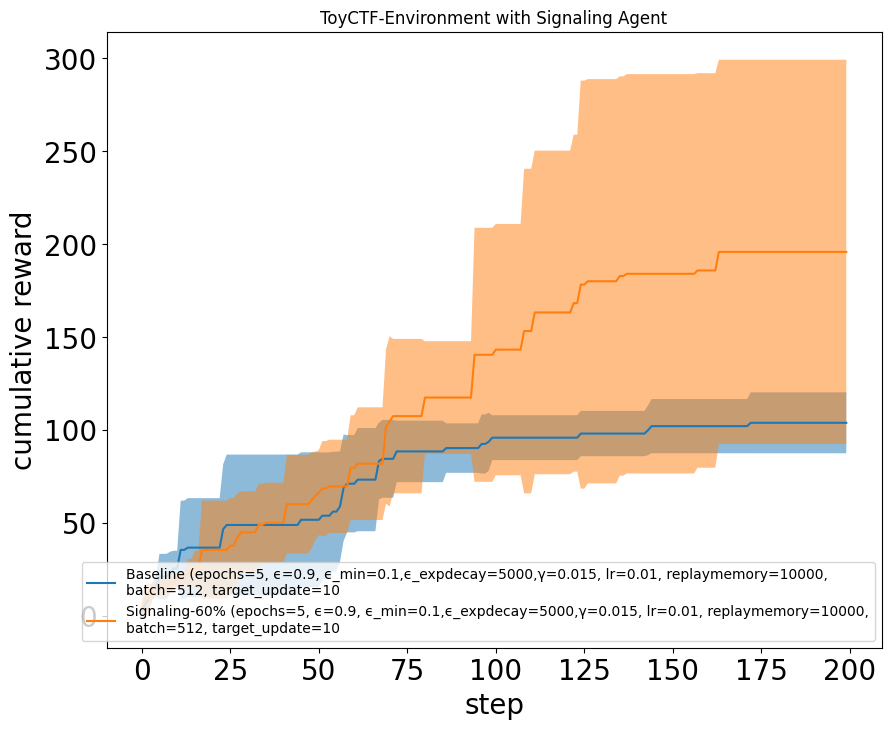

In [9]:
%matplotlib inline

#all_runs = [baseline_ctf_dql,signal20_ctf_dql,signal40_ctf_dql,signal60_ctf_dql]
all_runs = [baseline_ctf_dql,signal60_ctf_dql]
themodel = dqla.CyberBattleStateActionModel(ep)
plot = p.plot_averaged_cummulative_rewards(
    all_runs=all_runs,
    title=f"ToyCTF-Environment with Signaling Agent"
)


# 2. Environment - Chain+Signaling

In [ ]:
# Signaling Agent
# Chain Environment
env = env_chain_signaling_20
env.reset()
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

signal20_chain_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Signaling-20%",
)

In [ ]:
# Signaling Agent
# Chain Environment
env = env_chain_signaling_40
env.reset()
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

signal40_chain_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Signaling-40%",
)

In [ ]:
# Signaling Agent
# Chain Environment
env = env_chain_signaling_60
env.reset()
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

signal60_chain_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Signaling-60%",
)

In [ ]:
all_runs = [baseline_chain_dql,signal20_chain_dql, signal40_chain_dql,signal60_chain_dql]
# Plot averaged cumulative rewards for DQL vs Random vs DQL-Exploit
themodel = dqla.CyberBattleStateActionModel(ep)
p.plot_averaged_cummulative_rewards(
    all_runs=all_runs,
    title=f"Chain-Environment with Signaling Agent"
)


# 3. Environment - CTF+Tarpit

## 20%

In [ ]:
# Tarpit Agent
# CTF Environment
env = env_ctf_tarpitting_20
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

tarpit20_ctf_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Tarpit-20%",
)

## 40%

In [ ]:
# Tarpit Agent
# CTF Environment
env = env_ctf_tarpitting_40
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

tarpit40_ctf_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Tarpit-40%",
)

## 60%

In [10]:
# Tarpit Agent
# CTF Environment
env = env_ctf_tarpitting_60
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

tarpit60_ctf_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Tarpit-60%",
)

###### Tarpit-60%
Learning with: episode_count=5,iteration_count=200,ϵ=0.9,ϵ_min=0.1, ϵ_expdecay=5000,γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 0
INFO: Resetting the CyberBattle environment
  ## Episode: 1/5 'Tarpit-60%' ϵ=0.9000, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 0
INFO: Resetting the CyberBattle environment


Episode 1|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
[TarpitAgent] Deployed tarpit 'Tarpit_client' connected to 'client'
INFO: discovered node: Tarpit_client


Episode 1|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'


Episode 1|Iteration 6|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 7|reward:   11.0|last_reward_at:    7|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 1|Iteration 11|reward:   11.0|last_reward_at:    7|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 15|reward:   11.0|last_reward_at:    7|Elapsed Time: 0:00:00||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 1|Iteration 20|reward:   11.0|last_reward_at:    7|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 1|Iteration 22|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 26|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 1|Iteration 31|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'


Episode 1|Iteration 36|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 40|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 1|Iteration 42|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 44|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 1|Iteration 46|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 49|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'


Episode 1|Iteration 54|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 1|Iteration 56|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 61|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'


Episode 1|Iteration 64|reward:   22.0|last_reward_at:   22|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 1|Iteration 65|reward:   36.0|last_reward_at:   65|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'


Episode 1|Iteration 69|reward:   36.0|last_reward_at:   65|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'


Episode 1|Iteration 71|reward:   36.0|last_reward_at:   65|Elapsed Time: 0:00:01||

INFO: Infected node 'Tarpit-AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'
[TarpitAgent] Deployed tarpit 'Tarpit_Tarpit-AzureStorage' connected to 'Tarpit-AzureStorage'
INFO: discovered node: Tarpit_Tarpit-AzureStorage


Episode 1|Iteration 71|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 1|Iteration 74|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: invalid credentials supplied
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 1|Iteration 78|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: invalid credentials supplied


Episode 1|Iteration 82|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'


Episode 1|Iteration 84|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'


Episode 1|Iteration 87|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 1|Iteration 89|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: target node 'client' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 1|Iteration 92|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'


Episode 1|Iteration 94|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 1|Iteration 97|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 1|Iteration 102|reward:   86.0|last_reward_at:   71|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 1|Iteration 105|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:02||

INFO: invalid credentials supplied
INFO: GOT REWARD: Stole data using a publicly shared SAS token
INFO: target node 'client' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 1|Iteration 112|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 1|Iteration 117|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'


Episode 1|Iteration 122|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:02||

INFO: target node 'client' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'


Episode 1|Iteration 127|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:02||

INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: GOT REWARD: Stole data using a publicly shared SAS token
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'


Episode 1|Iteration 132|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 1|Iteration 140|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 1|Iteration 145|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: target node 'client' not listening on port 'HTTPS'


Episode 1|Iteration 152|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: invalid credentials supplied
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 1|Iteration 157|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'


Episode 1|Iteration 165|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 173|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 1|Iteration 175|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 1|Iteration 178|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'


Episode 1|Iteration 182|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'


Episode 1|Iteration 188|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'


Episode 1|Iteration 193|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 1|Iteration 198|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 1|Iteration 200|reward:   92.0|last_reward_at:  105|Elapsed Time: 0:00:03||


  Episode 1 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/33 (0.03)
    explore-remote: 3/98 (0.03)
    explore-connect: 1/59 (0.02)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/5 (0.00)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 14
  ## Episode: 2/5 'Tarpit-60%' ϵ=0.8688, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 0
INFO: Resetting the CyberBattle environment


Episode 2|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
[TarpitAgent] Deployed tarpit 'Tarpit_client' connected to 'client'
INFO: discovered node: Tarpit_client


Episode 2|Iteration 1|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 2|Iteration 8|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 2|Iteration 13|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 2|Iteration 15|reward:   22.0|last_reward_at:   15|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 23|reward:   22.0|last_reward_at:   15|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 2|Iteration 24|reward:   31.0|last_reward_at:   24|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 2|Iteration 33|reward:   31.0|last_reward_at:   24|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 2|Iteration 38|reward:   31.0|last_reward_at:   24|Elapsed Time: 0:00:00||

INFO: Infected node 'Website' from 'client' via SSH with credential 'ReusedMySqlCred-web'
INFO: Owned message: FLAG: Login using insecure SSH user/password
[TarpitAgent] Deployed tarpit 'Tarpit_Website' connected to 'Website'
INFO: discovered node: Tarpit_Website


Episode 2|Iteration 38|reward:  131.0|last_reward_at:   38|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 2|Iteration 44|reward:  131.0|last_reward_at:   38|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


Episode 2|Iteration 48|reward:  142.0|last_reward_at:   48|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: target node 'client' is blocking incoming traffic on port 'su'
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: Vulnerability 'ScanPageContent' not supported by node 'Sharepoint'


Episode 2|Iteration 56|reward:  142.0|last_reward_at:   48|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'
INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


Episode 2|Iteration 61|reward:  156.0|last_reward_at:   61|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: invalid credentials supplied
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website[user=monitor]'


Episode 2|Iteration 68|reward:  146.0|last_reward_at:   61|Elapsed Time: 0:00:00||

________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: invalid credentials supplied


Episode 2|Iteration 74|reward:  146.0|last_reward_at:   61|Elapsed Time: 0:00:00||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: invalid credentials supplied


Episode 2|Iteration 79|reward:  146.0|last_reward_at:   61|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website[user=monitor]'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 2|Iteration 80|reward:  136.0|last_reward_at:   61|Elapsed Time: 0:00:00||

INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'PING'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 2|Iteration 82|reward:  126.0|last_reward_at:   61|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 2|Iteration 84|reward:  116.0|last_reward_at:   61|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


Episode 2|Iteration 87|reward:  116.0|last_reward_at:   61|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: invalid credentials supplied
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 2|Iteration 91|reward:  116.0|last_reward_at:   61|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 2|Iteration 94|reward:  116.0|last_reward_at:   61|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 2|Iteration 96|reward:  116.0|last_reward_at:   61|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website[user=monitor]'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 2|Iteration 97|reward:  106.0|last_reward_at:   61|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


Episode 2|Iteration 102|reward:  106.0|last_reward_at:   61|Elapsed Time: 0:00:01||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website[user=monitor]'


Episode 2|Iteration 104|reward:  106.0|last_reward_at:   61|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: Vulnerability 'ListAzureResources' not supported by node 'Sharepoint'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Infected node 'Website[user=monitor]' from 'Website' via su with credential 'monitorBashCreds'
INFO: Owned message: FLAG User escalation by stealing credentials from bash history
[TarpitAgent] Deployed tarpit 'Tarpit_Website[user=monitor]' connected to 'Website[user=monitor]'
INFO: discovered node: Tarpit_Website[user=monitor]


Episode 2|Iteration 108|reward:  206.0|last_reward_at:  108|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


Episode 2|Iteration 110|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:01||

INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: target node 'Website[user=monitor]' is blocking incoming traffic on port 'SSH'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'AzureResourceManager[user=monitor]'
INFO: target node 'Sharepoint' not listening on port 'SSH'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'AzureResourceManager[user=monitor]'


Episode 2|Iteration 117|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:01||

INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'su'


Episode 2|Iteration 119|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Website[user=monitor]'
INFO: Vulnerability 'ScanPageContent' not supported by node 'AzureResourceManager[user=monitor]'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'


Episode 2|Iteration 122|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:01||

INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'GIT'


Episode 2|Iteration 125|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'
INFO: invalid credentials supplied
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'GIT'
INFO: target node 'client' not listening on port 'HTTPS'


Episode 2|Iteration 130|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'PING'


Episode 2|Iteration 135|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:02||

INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


Episode 2|Iteration 140|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


Episode 2|Iteration 147|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:02||

INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


Episode 2|Iteration 150|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with

Episode 2|Iteration 155|reward:  220.0|last_reward_at:  110|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Sharepoint'
INFO: discovered node: AzureResourceManager
INFO: discovered credential: CachedCredential(node='AzureResourceManager', port='HTTPS', credential='ADPrincipalCreds')
INFO: GOT REWARD: Navigating to the Sharepoint site revealed  AD Service Principal Credentials


Episode 2|Iteration 156|reward:  234.0|last_reward_at:  156|Elapsed Time: 0:00:02||

INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 2|Iteration 158|reward:  245.0|last_reward_at:  158|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'GIT'
INFO: target node 'AzureResourceManager' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'AzureResourceManager[user=monitor]'


Episode 2|Iteration 165|reward:  245.0|last_reward_at:  158|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ListAzureResources' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: invalid credentials supplied


Episode 2|Iteration 170|reward:  245.0|last_reward_at:  158|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'PING'


Episode 2|Iteration 175|reward:  245.0|last_reward_at:  158|Elapsed Time: 0:00:02||

INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: BLOCKED TRAFFIC: target node 'Website[user=monitor]' is blocking incoming traffic on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'


Episode 2|Iteration 180|reward:  245.0|last_reward_at:  158|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azure

Episode 2|Iteration 185|reward:  245.0|last_reward_at:  158|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


Episode 2|Iteration 193|reward:  245.0|last_reward_at:  158|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'GIT'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!
INFO: BLOCKED TRAFFIC: target node 'AzureResourceManager' is blocking incoming traffic on port 'su'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website[user=monitor]'


Episode 2|Iteration 198|reward:  245.0|last_reward_at:  158|Elapsed Time: 0:00:03||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website[user=monitor]'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'


Episode 2|Iteration 200|reward:  245.0|last_reward_at:  158|Elapsed Time: 0:00:03||


  Episode 2 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 2/25 (0.07)
    explore-remote: 5/84 (0.06)
    explore-connect: 2/67 (0.03)
    exploit-local: 1/14 (0.07)
    exploit-remote: 0/0 (NaN)
    exploit-connect: 0/0 (NaN)
  exploit deflected to exploration: 17
  ## Episode: 3/5 'Tarpit-60%' ϵ=0.8386, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 5
INFO: Resetting the CyberBattle environment


Episode 3|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
[TarpitAgent] Deployed tarpit 'Tarpit_client' connected to 'client'
INFO: discovered node: Tarpit_client


Episode 3|Iteration 1|reward:   11.0|last_reward_at:    1|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 3|Iteration 6|reward:   22.0|last_reward_at:    6|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 3|Iteration 9|reward:   36.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: target node 'client' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 3|Iteration 16|reward:   36.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 23|reward:   36.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 3|Iteration 28|reward:   36.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 3|Iteration 29|reward:   36.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'


Episode 3|Iteration 32|reward:   36.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 3|Iteration 34|reward:   36.0|last_reward_at:    9|Elapsed Time: 0:00:00||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 3|Iteration 35|reward:   47.0|last_reward_at:   35|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 3|Iteration 38|reward:   47.0|last_reward_at:   35|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: target node 'GitHubProject' not listening on port 'HTTPS'


Episode 3|Iteration 41|reward:   47.0|last_reward_at:   35|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 43|reward:   47.0|last_reward_at:   35|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 3|Iteration 46|reward:   37.0|last_reward_at:   35|Elapsed Time: 0:00:01||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 3|Iteration 47|reward:   27.0|last_reward_at:   35|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 3|Iteration 48|reward:   17.0|last_reward_at:   35|Elapsed Time: 0:00:01||

________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 53|reward:   17.0|last_reward_at:   35|Elapsed Time: 0:00:01||

INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 3|Iteration 54|reward:   18.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 3|Iteration 55|reward:    8.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 3|Iteration 59|reward:    8.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: target node 'Website.Directory' not listening on port 'SSH'


Episode 3|Iteration 61|reward:    8.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 3|Iteration 64|reward:    8.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 3|Iteration 66|reward:    8.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: target node 'Sharepoint' not listening on port 'SSH'


Episode 3|Iteration 69|reward:    8.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 3|Iteration 71|reward:    8.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 3|Iteration 74|reward:    8.0|last_reward_at:   54|Elapsed Time: 0:00:01||

INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: target node 'client' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 3|Iteration 78|reward:    8.0|last_reward_at:   54|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: GOT REWARD: Stole data using a publicly shared SAS token


Episode 3|Iteration 80|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Tarpit-AzureStorage'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'


Episode 3|Iteration 84|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 3|Iteration 87|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 91|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'


Episode 3|Iteration 94|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: invalid credentials supplied
INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit


Episode 3|Iteration 97|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 99|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 102|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 3|Iteration 106|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 3|Iteration 111|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 3|Iteration 117|reward:   14.0|last_reward_at:   80|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 3|Iteration 117|reward:   23.0|last_reward_at:  117|Elapsed Time: 0:00:02||

INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 3|Iteration 120|reward:   23.0|last_reward_at:  117|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 3|Iteration 122|reward:   23.0|last_reward_at:  117|Elapsed Time: 0:00:03||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 3|Iteration 124|reward:   23.0|last_reward_at:  117|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'


Episode 3|Iteration 129|reward:   23.0|last_reward_at:  117|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


Episode 3|Iteration 132|reward:   23.0|last_reward_at:  117|Elapsed Time: 0:00:03||

INFO: target node 'Tarpit-AzureStorage' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 135|reward:   23.0|last_reward_at:  117|Elapsed Time: 0:00:03||

INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: invalid credentials supplied


Episode 3|Iteration 139|reward:   23.0|last_reward_at:  117|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Infected node 'Tarpit-AzureStorage' from 'client' via HTTPS with credential 'SASTOKEN1'
[TarpitAgent] Deployed tarpit 'Tarpit_Tarpit-AzureStorage' connected to 'Tarpit-AzureStorage'
INFO: discovered node: Tarpit_Tarpit-AzureStorage


Episode 3|Iteration 141|reward:   73.0|last_reward_at:  141|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 3|Iteration 144|reward:   73.0|last_reward_at:  141|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'


Episode 3|Iteration 146|reward:   73.0|last_reward_at:  141|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'


Episode 3|Iteration 149|reward:   73.0|last_reward_at:  141|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'su'


Episode 3|Iteration 152|reward:   73.0|last_reward_at:  141|Elapsed Time: 0:00:04||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 154|reward:   73.0|last_reward_at:  141|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 3|Iteration 157|reward:   73.0|last_reward_at:  141|Elapsed Time: 0:00:04||

INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: target node 'Website.Directory' not listening on port 'SSH'


Episode 3|Iteration 158|reward:   73.0|last_reward_at:  141|Elapsed Time: 0:00:04||

INFO: target node 'GitHubProject' not listening on port 'SSH'


Episode 3|Iteration 160|reward:   73.0|last_reward_at:  141|Elapsed Time: 0:00:04||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'


Episode 3|Iteration 162|reward:   73.0|last_reward_at:  141|Elapsed Time: 0:00:04||

INFO: discovered node: AzureResourceManager
INFO: discovered credential: CachedCredential(node='AzureResourceManager', port='HTTPS', credential='ADPrincipalCreds')
INFO: GOT REWARD: Navigating to the Sharepoint site revealed  AD Service Principal Credentials


Episode 3|Iteration 163|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:04||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 167|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:04||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Tarpit-AzureStorage'


Episode 3|Iteration 170|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:05||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 3|Iteration 171|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'PING'


Episode 3|Iteration 173|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 175|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanPageSource' not supported by node 'AzureResourceManager'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 177|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 3|Iteration 179|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'


Episode 3|Iteration 182|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:05||

INFO: discovered node: Tarpit-AzureStorage
INFO: discovered credential: CachedCredential(node='Tarpit-AzureStorage', port='HTTPS', credential='SASTOKEN1')
INFO: GOT REWARD: CredScan success: Some secure access token (SAS) was leaked in a reverted git commit
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 3|Iteration 185|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:05||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 3|Iteration 187|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:05||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 3|Iteration 189|reward:   87.0|last_reward_at:  163|Elapsed Time: 0:00:05||

INFO: Infected node 'AzureResourceManager' from 'client' via HTTPS with credential 'ADPrincipalCreds'
INFO: Owned message: FLAG: Shared credentials with database user - Obtained secrets hidden in Azure Managed Resources
[TarpitAgent] Deployed tarpit 'Tarpit_AzureResourceManager' connected to 'AzureResourceManager'
INFO: discovered node: Tarpit_AzureResourceManager


Episode 3|Iteration 190|reward:  137.0|last_reward_at:  190|Elapsed Time: 0:00:06||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Tarpit-AzureStorage'
INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'GIT'


Episode 3|Iteration 192|reward:  137.0|last_reward_at:  190|Elapsed Time: 0:00:06||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'


Episode 3|Iteration 194|reward:  137.0|last_reward_at:  190|Elapsed Time: 0:00:06||

INFO: BLOCKED TRAFFIC: source node 'Tarpit-AzureStorage' is blocking outgoing traffic on port 'MySQL'
INFO: target node 'Sharepoint' not listening on port 'SSH'
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'PING'


Episode 3|Iteration 197|reward:  137.0|last_reward_at:  190|Elapsed Time: 0:00:06||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'AzureResourceManager'
INFO: invalid credentials supplied


Episode 3|Iteration 200|reward:  137.0|last_reward_at:  190|Elapsed Time: 0:00:06||


  Episode 3 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/30 (0.03)
    explore-remote: 7/66 (0.10)
    explore-connect: 0/73 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 0/16 (0.00)
    exploit-connect: 2/5 (0.29)
  exploit deflected to exploration: 9
  ## Episode: 4/5 'Tarpit-60%' ϵ=0.8097, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 5
INFO: Resetting the CyberBattle environment


Episode 4|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
[TarpitAgent] Deployed tarpit 'Tarpit_client' connected to 'client'
INFO: discovered node: Tarpit_client


Episode 4|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 4|Iteration 3|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 4|Iteration 6|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'


Episode 4|Iteration 8|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 8|reward:   11.0|last_reward_at:    8|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 4|Iteration 11|reward:   11.0|last_reward_at:    8|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'


Episode 4|Iteration 13|reward:   11.0|last_reward_at:    8|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 4|Iteration 15|reward:   11.0|last_reward_at:    8|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'


Episode 4|Iteration 18|reward:   11.0|last_reward_at:    8|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'


Episode 4|Iteration 20|reward:   11.0|last_reward_at:    8|Elapsed Time: 0:00:00||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website'


Episode 4|Iteration 23|reward:   11.0|last_reward_at:    8|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 25|reward:   11.0|last_reward_at:    8|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 4|Iteration 27|reward:   22.0|last_reward_at:   27|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 31|reward:   22.0|last_reward_at:   27|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 4|Iteration 34|reward:   31.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 38|reward:   31.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 4|Iteration 40|reward:   31.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 4|Iteration 44|reward:   31.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 46|reward:   31.0|last_reward_at:   34|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Infected node 'Website' from 'client' via SSH with credential 'ReusedMySqlCred-web'
INFO: Owned message: FLAG: Login using insecure SSH user/password
[TarpitAgent] Deployed tarpit 'Tarpit_Website' connected to 'Website'
INFO: discovered node: Tarpit_Website


Episode 4|Iteration 47|reward:  131.0|last_reward_at:   47|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website.Directory'


Episode 4|Iteration 51|reward:  131.0|last_reward_at:   47|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 4|Iteration 52|reward:  131.0|last_reward_at:   47|Elapsed Time: 0:00:01||

INFO: target node 'client' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


Episode 4|Iteration 55|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: target node 'Website[user=monitor]' not listening on port 'HTTPS'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website[user=monitor]'


Episode 4|Iteration 59|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:01||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: target node 'Website[user=monitor]' not listening on port 'HTTPS'


Episode 4|Iteration 61|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: target node 'Website[user=monitor]' not listening on port 'HTTPS'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 4|Iteration 63|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website[user=monitor]'


Episode 4|Iteration 65|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:02||

INFO: invalid credentials supplied
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: target node 'Website[user=monitor]' is blocking incoming traffic on port 'SSH'


Episode 4|Iteration 68|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website[user=monitor]'


Episode 4|Iteration 70|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 4|Iteration 72|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'


Episode 4|Iteration 75|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website[user=monitor]'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: invalid credentials supplied


Episode 4|Iteration 79|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 82|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'SSH-key'


Episode 4|Iteration 84|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:02||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 4|Iteration 87|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website[user=monitor]'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 4|Iteration 91|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: target node 'Website[user=monitor]' not listening on port 'HTTPS'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'


Episode 4|Iteration 94|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'PING'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 4|Iteration 97|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


Episode 4|Iteration 101|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website[user=monitor]'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: Vulnerability 'ScanPageSource' not supported by node 'Website[user=monitor]'


Episode 4|Iteration 105|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 4|Iteration 109|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'


Episode 4|Iteration 110|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 4|Iteration 112|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: target node 'Website' is blocking incoming traffic on port 'su'


Episode 4|Iteration 114|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 4|Iteration 117|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


Episode 4|Iteration 117|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:03||

INFO: invalid credentials supplied


Episode 4|Iteration 119|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:04||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website[user=monitor]'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 4|Iteration 122|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:04||

INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: target node 'Website[user=monitor]' not listening on port 'HTTPS'


Episode 4|Iteration 124|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:04||

INFO: target node 'Website[user=monitor]' not listening on port 'HTTPS'
INFO: target node 'Website[user=monitor]' not listening on port 'HTTPS'


Episode 4|Iteration 127|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:04||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


Episode 4|Iteration 129|reward:  145.0|last_reward_at:   55|Elapsed Time: 0:00:04||

INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


Episode 4|Iteration 130|reward:  156.0|last_reward_at:  130|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: target node 'Website[user=monitor]' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


Episode 4|Iteration 134|reward:  156.0|last_reward_at:  130|Elapsed Time: 0:00:04||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 4|Iteration 135|reward:  146.0|last_reward_at:  130|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'


Episode 4|Iteration 140|reward:  146.0|last_reward_at:  130|Elapsed Time: 0:00:04||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


Episode 4|Iteration 142|reward:  146.0|last_reward_at:  130|Elapsed Time: 0:00:04||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: invalid credentials supplied


Episode 4|Iteration 145|reward:  146.0|last_reward_at:  130|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanPageSource' not supported by node 'Website[user=monitor]'
INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)


Episode 4|Iteration 146|reward:  146.0|last_reward_at:  130|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: target node 'client' is blocking incoming traffic on port 'su'


Episode 4|Iteration 148|reward:  146.0|last_reward_at:  130|Elapsed Time: 0:00:05||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'


Episode 4|Iteration 149|reward:  136.0|last_reward_at:  130|Elapsed Time: 0:00:05||

________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 4|Iteration 151|reward:  136.0|last_reward_at:  130|Elapsed Time: 0:00:05||

INFO: discovered node: Website[user=monitor]
INFO: discovered credential: CachedCredential(node='Website[user=monitor]', port='SSH', credential='monitorBashCreds')
INFO: GOT REWARD: FLAG: SSH history revealed credentials for the monitoring user (monitor)
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 4|Iteration 154|reward:  136.0|last_reward_at:  130|Elapsed Time: 0:00:05||

INFO: target node 'client' not listening on port 'SSH'
INFO: invalid credentials supplied


Episode 4|Iteration 157|reward:  136.0|last_reward_at:  130|Elapsed Time: 0:00:05||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'
INFO: Infected node 'Website[user=monitor]' from 'Website' via su with credential 'monitorBashCreds'
INFO: Owned message: FLAG User escalation by stealing credentials from bash history
[TarpitAgent] Deployed tarpit 'Tarpit_Website[user=monitor]' connected to 'Website[user=monitor]'
INFO: discovered node: Tarpit_Website[user=monitor]


Episode 4|Iteration 158|reward:  236.0|last_reward_at:  158|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'SSH-key'
INFO: target node 'Sharepoint' not listening on port 'SSH'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 4|Iteration 160|reward:  226.0|last_reward_at:  158|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 163|reward:  226.0|last_reward_at:  158|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: target node 'client' is blocking incoming traffic on port 'su'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


Episode 4|Iteration 164|reward:  240.0|last_reward_at:  164|Elapsed Time: 0:00:05||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website[user=monitor]'
INFO: discovered node: AzureResourceManager[user=monitor]
INFO: discovered credential: CachedCredential(node='AzureResourceManager[user=monitor]', port='HTTPS', credential='azuread_user_credentials')
INFO: GOT REWARD: SSH: cat ~/azurecreds.txt (running as monitor) revealed Azure user credential!


Episode 4|Iteration 166|reward:  240.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'


Episode 4|Iteration 167|reward:  230.0|last_reward_at:  164|Elapsed Time: 0:00:06||

________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________
INFO: BLOCKED TRAFFIC: target node 'AzureResourceManager[user=monitor]' is blocking incoming traffic on port 'su'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'


Episode 4|Iteration 170|reward:  230.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'GIT'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 4|Iteration 170|reward:  220.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


Episode 4|Iteration 172|reward:  220.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'


Episode 4|Iteration 175|reward:  220.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website[user=monitor]'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'


Episode 4|Iteration 178|reward:  220.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 4|Iteration 180|reward:  220.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 4|Iteration 181|reward:  220.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'AzureResourceManager[user=monitor]'
INFO: Vulnerability 'ScanPageSource' not supported by node 'AzureResourceManager[user=monitor]'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'


Episode 4|Iteration 185|reward:  220.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'Website' is blocking outgoing traffic on port 'MySQL'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 4|Iteration 188|reward:  220.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'


Episode 4|Iteration 190|reward:  220.0|last_reward_at:  164|Elapsed Time: 0:00:06||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'AzureResourceManager[user=monitor]'
INFO: Infected node 'AzureResourceManager[user=monitor]' from 'client' via HTTPS with credential 'azuread_user_credentials'
INFO: Owned message: More secrets stolen when logged as interactive `monitor` user in Azure with `az`
[TarpitAgent] Deployed tarpit 'Tarpit_AzureResourceManager[user=monitor]' connected to 'AzureResourceManager[user=monitor]'
INFO: discovered node: Tarpit_AzureResourceManager[user=monitor]


Episode 4|Iteration 192|reward:  270.0|last_reward_at:  192|Elapsed Time: 0:00:07||

INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'PING'
INFO: target node 'Sharepoint' not listening on port 'SSH'


Episode 4|Iteration 195|reward:  270.0|last_reward_at:  192|Elapsed Time: 0:00:07||

INFO: target node 'AzureResourceManager[user=monitor]' not listening on port 'SSH'
INFO: Vulnerability 'ListAzureResources' not supported by node 'AzureResourceManager[user=monitor]'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website[user=monitor]'


Episode 4|Iteration 198|reward:  270.0|last_reward_at:  192|Elapsed Time: 0:00:07||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'Website[user=monitor]' is blocking outgoing traffic on port 'su'
INFO: target node 'Sharepoint' not listening on port 'SSH'


Episode 4|Iteration 200|reward:  270.0|last_reward_at:  192|Elapsed Time: 0:00:07||


  Episode 4 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 3/26 (0.10)
    explore-remote: 3/81 (0.04)
    explore-connect: 1/56 (0.02)
    exploit-local: 0/8 (0.00)
    exploit-remote: 0/10 (0.00)
    exploit-connect: 2/10 (0.17)
  exploit deflected to exploration: 8
  ## Episode: 5/5 'Tarpit-60%' ϵ=0.7819, γ=0.015, lr=0.01, replaymemory=10000,
batch=512, target_update=10
Total Applied Penalties: 5
INFO: Resetting the CyberBattle environment


Episode 5|Iteration 0|reward: ------|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
[TarpitAgent] Deployed tarpit 'Tarpit_client' connected to 'client'
INFO: discovered node: Tarpit_client


Episode 5|Iteration 1|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 5|Iteration 5|reward:    0.0|last_reward_at: ----|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 6|reward:   11.0|last_reward_at:    6|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website


Episode 5|Iteration 10|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website'


Episode 5|Iteration 13|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'client'


Episode 5|Iteration 15|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:00||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'


Episode 5|Iteration 19|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:00||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: Vulnerability 'ScanPageSource' not supported by node 'client'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 23|reward:   22.0|last_reward_at:   10|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 5|Iteration 23|reward:   31.0|last_reward_at:   23|Elapsed Time: 0:00:00||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: discovered node: Website
INFO: discovered credential: CachedCredential(node='Website', port='MySQL', credential='ReusedMySqlCred-web')
INFO: GOT REWARD: Discover browseable web directory: Navigating to parent URL revealed file `readme.txt`with secret data (aflag); and `getting-started.txt` with MYSQL credentials


Episode 5|Iteration 26|reward:   31.0|last_reward_at:   23|Elapsed Time: 0:00:00||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 28|reward:   31.0|last_reward_at:   23|Elapsed Time: 0:00:00||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: target node 'client' not listening on port 'SSH'


Episode 5|Iteration 30|reward:   31.0|last_reward_at:   23|Elapsed Time: 0:00:00||

INFO: invalid credentials supplied
INFO: target node 'client' not listening on port 'SSH'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 5|Iteration 35|reward:   31.0|last_reward_at:   23|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: invalid credentials supplied


Episode 5|Iteration 38|reward:   31.0|last_reward_at:   23|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: invalid credentials supplied
INFO: invalid credentials supplied


Episode 5|Iteration 41|reward:   31.0|last_reward_at:   23|Elapsed Time: 0:00:01||

INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: invalid credentials supplied
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 44|reward:   31.0|last_reward_at:   23|Elapsed Time: 0:00:01||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: target node 'client' not listening on port 'HTTPS'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Website.Directory'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 48|reward:   31.0|last_reward_at:   23|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!


Episode 5|Iteration 50|reward:   42.0|last_reward_at:   50|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 5|Iteration 54|reward:   42.0|last_reward_at:   50|Elapsed Time: 0:00:01||

INFO: invalid credentials supplied
INFO: target node 'GitHubProject' not listening on port 'HTTPS'
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website


Episode 5|Iteration 56|reward:   53.0|last_reward_at:   56|Elapsed Time: 0:00:01||

INFO: invalid credentials supplied
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 5|Iteration 61|reward:   53.0|last_reward_at:   56|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 5|Iteration 62|reward:   43.0|last_reward_at:   56|Elapsed Time: 0:00:01||

________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________
INFO: Vulnerability 'ListAzureResources' not supported by node 'Sharepoint'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 5|Iteration 63|reward:   33.0|last_reward_at:   56|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'


Episode 5|Iteration 68|reward:   33.0|last_reward_at:   56|Elapsed Time: 0:00:01||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 5|Iteration 70|reward:   23.0|last_reward_at:   56|Elapsed Time: 0:00:01||

INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Sharepoint'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 5|Iteration 71|reward:   13.0|last_reward_at:   56|Elapsed Time: 0:00:01||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
________________________________________
!!!Interacted with Node: Tarpit-AzureStorage
________________________________________


Episode 5|Iteration 72|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:01||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 5|Iteration 76|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:01||

INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 79|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: target node 'Website.Directory' not listening on port 'SSH'


Episode 5|Iteration 82|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: discovered node: Sharepoint
INFO: GOT REWARD: Navigating to parent URL revealed file `deprecation-checklist.txt` containinga URL to an external sharepoint website
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 5|Iteration 87|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: invalid credentials supplied
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'Sharepoint'
INFO: invalid credentials supplied


Episode 5|Iteration 91|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: target node 'client' not listening on port 'HTTPS'
INFO: target node 'Website.Directory' not listening on port 'SSH'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ScanPageContent' not supported by node 'Sharepoint'


Episode 5|Iteration 96|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: invalid credentials supplied
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'client'


Episode 5|Iteration 101|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:02||

INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'Sharepoint'
INFO: invalid credentials supplied
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'


Episode 5|Iteration 107|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:02||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: invalid credentials supplied
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'client'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Website.Directory'
INFO: invalid credentials supplied


Episode 5|Iteration 111|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'ScanPageContent' not supported by node 'Sharepoint'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'


Episode 5|Iteration 117|reward:    3.0|last_reward_at:   56|Elapsed Time: 0:00:02||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'GitHubProject'
INFO: discovered node: AzureResourceManager
INFO: discovered credential: CachedCredential(node='AzureResourceManager', port='HTTPS', credential='ADPrincipalCreds')
INFO: GOT REWARD: Navigating to the Sharepoint site revealed  AD Service Principal Credentials


Episode 5|Iteration 118|reward:   17.0|last_reward_at:  118|Elapsed Time: 0:00:02||

INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'AzureResourceManager'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 122|reward:   17.0|last_reward_at:  118|Elapsed Time: 0:00:02||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'AzureResourceManager'
INFO: target node 'Website.Directory' not listening on port 'SSH'


Episode 5|Iteration 125|reward:   17.0|last_reward_at:  118|Elapsed Time: 0:00:02||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'AzureResourceManager'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'AzureResourceManager'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website.Directory'
INFO: Vulnerability 'ListAzureResources' not supported by node 'Sharepoint'


Episode 5|Iteration 130|reward:   17.0|last_reward_at:  118|Elapsed Time: 0:00:03||

INFO: discovered node: GitHubProject
INFO: GOT REWARD: WEBSITE page content has a link to github -> Github project discovered!
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'AzureResourceManager'


Episode 5|Iteration 134|reward:   17.0|last_reward_at:  118|Elapsed Time: 0:00:03||

INFO: target node 'AzureResourceManager' not listening on port 'SSH'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'AzureResourceManager'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'


Episode 5|Iteration 139|reward:   17.0|last_reward_at:  118|Elapsed Time: 0:00:04||

INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Website'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'MySQL'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'


Episode 5|Iteration 145|reward:   17.0|last_reward_at:  118|Elapsed Time: 0:00:04||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'


Episode 5|Iteration 150|reward:   17.0|last_reward_at:  118|Elapsed Time: 0:00:04||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: invalid credentials supplied


Episode 5|Iteration 154|reward:   17.0|last_reward_at:  118|Elapsed Time: 0:00:04||

INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'SSH-key'
INFO: Infected node 'AzureResourceManager' from 'client' via HTTPS with credential 'ADPrincipalCreds'
INFO: Owned message: FLAG: Shared credentials with database user - Obtained secrets hidden in Azure Managed Resources
[TarpitAgent] Deployed tarpit 'Tarpit_AzureResourceManager' connected to 'AzureResourceManager'
INFO: discovered node: Tarpit_AzureResourceManager


Episode 5|Iteration 157|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: invalid credentials supplied
INFO: target node 'GitHubProject' not listening on port 'HTTPS'


Episode 5|Iteration 160|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ScanPageSource' not supported by node 'GitHubProject'
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'AzureResourceManager'
INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest


Episode 5|Iteration 163|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: discovered node: Website
INFO: GOT REWARD: Web browser history revealed website URL of interest
INFO: Vulnerability 'ListAzureResources' not supported by node 'Sharepoint'
INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'GitHubProject'
INFO: Vulnerability 'AccessDataWithSASToken' not supported by node 'client'


Episode 5|Iteration 167|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: target node 'GitHubProject' not listening on port 'HTTPS'


Episode 5|Iteration 170|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: target node 'client' not listening on port 'HTTPS'
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'su'


Episode 5|Iteration 173|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'GIT'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'client'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'
INFO: invalid credentials supplied
INFO: invalid credentials supplied


Episode 5|Iteration 177|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: Vulnerability 'ListAzureResources' not supported by node 'client'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'Website'


Episode 5|Iteration 180|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'PING'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'


Episode 5|Iteration 183|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'PING'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: Vulnerability 'CredScanGitHistory' not supported by node 'Website.Directory'
INFO: Vulnerability 'ScanSharepointParentDirectory' not supported by node 'AzureResourceManager'


Episode 5|Iteration 187|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'su'
INFO: invalid credentials supplied
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'PING'
INFO: target node 'client' not listening on port 'SSH'


Episode 5|Iteration 192|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:05||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'client'
INFO: discovered node: Website.Directory
INFO: GOT REWARD: Viewing the web page source reveals a URL to a .txt file and directory on the website
INFO: Vulnerability 'NavigateWebDirectory' not supported by node 'Sharepoint'
INFO: target node 'GitHubProject' not listening on port 'SSH'
INFO: Vulnerability 'ScanPageContent' not supported by node 'GitHubProject'


Episode 5|Iteration 198|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:06||

INFO: Vulnerability 'NavigateWebDirectoryFurther' not supported by node 'GitHubProject'
INFO: BLOCKED TRAFFIC: source node 'AzureResourceManager' is blocking outgoing traffic on port 'GIT'
INFO: BLOCKED TRAFFIC: source node 'client' is blocking outgoing traffic on port 'PING'


Episode 5|Iteration 200|reward:   67.0|last_reward_at:  157|Elapsed Time: 0:00:06||


  Episode 5 stopped at t=200 
  Breakdown [Reward/NoReward (Success rate)]
    explore-local: 1/23 (0.04)
    explore-remote: 1/64 (0.02)
    explore-connect: 0/60 (0.00)
    exploit-local: 0/0 (NaN)
    exploit-remote: 4/25 (0.14)
    exploit-connect: 1/21 (0.05)
  exploit deflected to exploration: 7
simulation ended


## Evaluation

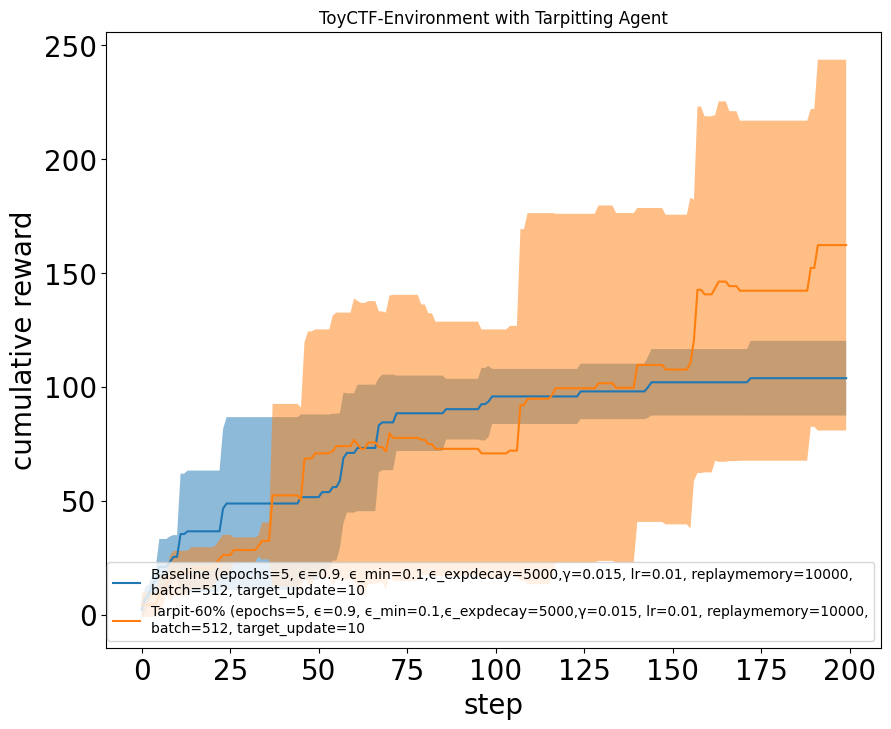

In [11]:
#all_runs = [baseline_ctf_dql,tarpit20_ctf_dql,tarpit40_ctf_dql,tarpit60_ctf_dql]
all_runs = [baseline_ctf_dql,tarpit60_ctf_dql]

themodel = dqla.CyberBattleStateActionModel(ep)
p.plot_averaged_cummulative_rewards(
    all_runs=all_runs,
    title=f"ToyCTF-Environment with Tarpitting Agent"
)


# 4. Environment - Chain+Tarpit

In [ ]:
# Tarpit Agent
# Chain Environment
env = env_chain_tarpitting_20
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

tarpit20_chain_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Tarpit-20%",
)

In [ ]:
# Tarpit Agent
# Chain Environment
env = env_chain_tarpitting_40
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

tarpit40_chain_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Tarpit-40%",
)

In [ ]:
# Tarpit Agent
# Chain Environment
env = env_chain_tarpitting_60
ep = w.EnvironmentBounds.of_identifiers(maximum_node_count=maximum_node_count, maximum_total_credentials=maximum_total_credentials, identifiers=env.identifiers)

tarpit60_chain_dql = learner.epsilon_greedy_search(
    cyberbattle_gym_env=env,
    environment_properties=ep,
    learner=dqla.DeepQLearnerPolicy(
        ep=ep,
        gamma=0.015,
        replay_memory_size=10000,
        target_update=10,
        batch_size=512,
        # torch default learning rate is 1e-2
        # a large value helps converge in less episodes
        learning_rate=0.01,
    ),
    episode_count=training_episode_count,
    iteration_count=iteration_count,
    epsilon=0.90,
    epsilon_exponential_decay=5000,
    epsilon_minimum=0.10,
    verbosity=Verbosity.Quiet,
    render=False,
    plot_episodes_length=False,
    title="Tarpit-60%",
)

In [ ]:
all_runs = [baseline_chain_dql,tarpit20_chain_dql, tarpit40_chain_dql,tarpit60_chain_dql]

themodel = dqla.CyberBattleStateActionModel(ep)
p.plot_averaged_cummulative_rewards(
    all_runs=all_runs,
    title=f"Chain-Environment with Tarpitting Agent"
)

